<h1><center> Road Traffic Accidents Severity Classification </center></h1>

### Contents

- Introduction
- Exploratory Data Analysis
- Data Preprocessing
- Baseline Models
- Hyperparameter Tuning
- Explainable AI
- Acknowledgements
- References

### Importing necessary libraries

In [1]:
# File system manangement
import time, psutil, os

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Missing data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Categorical data encoding
from sklearn.preprocessing import LabelEncoder

# Train-test split and k-fold cross validation
from sklearn.model_selection import train_test_split, KFold,  GridSearchCV

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Resampling
import imblearn
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import f1_score

# Explainable AI
!pip install --quiet shap==0.39.0
import shap

# Warning suppression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Recording the starting time, which will be complemented with a time check at the end, to compute the total runtime of the process
start = time.time()

# 1. Introduction

## 1.1. Data

Source: https://www.kaggle.com/saurabhshahane/road-traffic-accidents

The dataset has been prepared from manual records of road traffic accidents in the year 2017-2020, collected from Addis Ababa sub city police departments. Sensitive information have been excluded during the data encoding process. The final dataset has information on **12316 accidents**, each with **32 features**.

In [3]:
# Loading the data
data = pd.read_csv('https://raw.githubusercontent.com/sugatagh/Road-Traffic-Accident-Severity-Classification/main/Dataset/RTA%20Dataset.csv')

In [4]:
# Printing the top 5 rows
data.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                     NaN  ...   Going straight   
3     Governmental                     NaN  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0               NaN                  NaN    Not a Pedestrian   
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4               NaN                  NaN    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

## 1.2. Project Objective

The dataset contains extensive information on **12316 accidents**. It has **31 predictor variables** and the **target variable** *Accident_severity* which takes three possible values: **Slight**, **Serious** and **Fatal**. The aim of the project is to build prediction models to classify whether the severity of an accident is slight, serious or fatal, given various relevant information in form of the 31 predictor variables, regarding that particular accident.

## 1.3. Evaluation Metric

**Precision** and **Recall** are universally accepted metrics to capture the performance of a model, when restricted respectively to the **predicted positive class** and the **actual positive class**. Let us denote
- **TP**: Number of true positives
- **TN**: Number of true negatives
- **FP**: Number of false positives
- **FN**: Number of false negatives

In terms of these quantities, **Precision** and **Recall** are defined as

$$\text{Precision} = \frac{TP}{TP + FP},\hspace{0.5cm} \text{Recall} = \frac{TP}{TP + FN}.$$

The **F1-score** provides a balanced measuring stick by considering the *harmonic mean* of the above two matrices.

$$F_1\text{-Score} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}.$$

For its equal emphasis on both *precision* and *recall*, *F1-score* is one of the most suitable metrics for evaluating the models in this project. In the dataset, we have a target variable (*Accident_severity*) that takes three possible values, essentially partitioning the dataset into three target classes. This can be converted to a binary partition by considering one class as the positive class and the rest two combined as the negative class. Now this positive-negative partition can be done from the perspective of each target class, producing three F1-scores. We take the unweighted average (called the **macro F1-score**) as an evaluation metric to assess the models.

# 2. Exploratory Data Analysis

## 2.1. Basic Data Exploration

In [5]:
# Shape of the data
print("Shape of the data: {}".format(data.shape))

Shape of the data: (12316, 32)


In [6]:
# Column names
data.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [7]:
print("Total number of columns: {}".format(len(data.columns)))

Total number of columns: 32


In [8]:
# Column datatypes
data.dtypes

Time                           object
Day_of_week                    object
Age_band_of_driver             object
Sex_of_driver                  object
Educational_level              object
Vehicle_driver_relation        object
Driving_experience             object
Type_of_vehicle                object
Owner_of_vehicle               object
Service_year_of_vehicle        object
Defect_of_vehicle              object
Area_accident_occured          object
Lanes_or_Medians               object
Road_allignment                object
Types_of_Junction              object
Road_surface_type              object
Road_surface_conditions        object
Light_conditions               object
Weather_conditions             object
Type_of_collision              object
Number_of_vehicles_involved     int64
Number_of_casualties            int64
Vehicle_movement               object
Casualty_class                 object
Sex_of_casualty                object
Age_band_of_casualty           object
Casualty_sev

In [9]:
print("Number of integer columns: {}".format(data.dtypes.tolist().count(data.dtypes[0])))
print("Number of object columns: {}".format(data.dtypes.tolist().count(data.dtypes[20])))

Number of integer columns: 30
Number of object columns: 2


In [10]:
# Count of duplicate rows
duplicate = data[data.duplicated() == True]
print("Number of duplicate rows: {}".format(len(duplicate)))

Number of duplicate rows: 0


In [11]:
# Count of missing values in each column
data.isna().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [12]:
print("Total number of missing values: {}".format(data.isna().sum().sum()))
print("Number of columns with missing values: {}".format(len(data.isnull().sum().tolist())-data.isnull().sum().tolist().count(0)))
print("Number of columns without missing values: {}".format(data.isnull().sum().tolist().count(0)))

Total number of missing values: 20057
Number of columns with missing values: 16
Number of columns without missing values: 16


In [13]:
# Summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

Data synopsis:

- Number of observations: 12316
- Number of columns: 32
- Memory Usage: 3.0+ MB
- Number of integer columns: 2
- Number of object columns: 30
- Number of columns with missing values: 16
- Columns with missing values: Educational_level, Vehicle_driver_relation, Driving_experience, Type_of_vehicle, Owner_of_vehicle, Service_year_of_vehicle, Defect_of_vehicle, Area_accident_occured, Lanes_or_Medians, Road_allignment, Types_of_Junction, Road_surface_type, Type_of_collision, Vehicle_movement, Work_of_casuality, Fitness_of_casuality

In [14]:
# Count of duplicates
print("Number of duplicate observations: {}".format(data.duplicated().sum()))

Number of duplicate observations: 0


In [15]:
# Statistical description of numerical features
data.describe()

Number_of_vehicles_involved  Number_of_casualties
count                 12316.000000          12316.000000
mean                      2.040679              1.548149
std                       0.688790              1.007179
min                       1.000000              1.000000
25%                       2.000000              1.000000
50%                       2.000000              1.000000
75%                       2.000000              2.000000
max                       7.000000              8.000000

In [16]:
# Total count, unique count, mode value and mode frequency of all features
data.describe(include = "all").head(4).T

count unique  \
Time                           12316   1074   
Day_of_week                    12316      7   
Age_band_of_driver             12316      5   
Sex_of_driver                  12316      3   
Educational_level              11575      7   
Vehicle_driver_relation        11737      4   
Driving_experience             11487      7   
Type_of_vehicle                11366     17   
Owner_of_vehicle               11834      4   
Service_year_of_vehicle         8388      6   
Defect_of_vehicle               7889      3   
Area_accident_occured          12077     14   
Lanes_or_Medians               11931      7   
Road_allignment                12174      9   
Types_of_Junction              11429      8   
Road_surface_type              12144      5   
Road_surface_conditions        12316      4   
Light_conditions               12316      4   
Weather_conditions             12316      9   
Type_of_collision              12161     10   
Number_of_vehicles_involved  12316.0    NaN   
Number_of_casualties         12316.0    NaN   
Vehicle_movement               12008     13   
Casualty_class                 12316      4   
Sex_of_casualty                12316      3   
Age_band_of_casualty           12316      6   
Casualty_severity              12316      4   
Work_of_casuality               9118      7   
Fitness_of_casuality            9681      5   
Pedestrian_movement            12316      9   
Cause_of_accident              12316     20   
Accident_severity              12316      3   

                                                                          top  \
Time                                                                 15:30:00   
Day_of_week                                                            Friday   
Age_band_of_driver                                                      18-30   
Sex_of_driver                                                            Male   
Educational_level                                          Junior high school   
Vehicle_driver_relation                                              Employee   
Driving_experience                                                     5-10yr   
Type_of_vehicle                                                    Automobile   
Owner_of_vehicle                                                        Owner   
Service_year_of_vehicle                                               Unknown   
Defect_of_vehicle                                                   No defect   
Area_accident_occured                                                   Other   
Lanes_or_Medians             Two-way (divided with broken lines road marking)   
Road_allignment                                Tangent road with flat terrain   
Types_of_Junction                                                     Y Shape   
Road_surface_type                                               Asphalt roads   
Road_surface_conditions                                                   Dry   
Light_conditions                                                     Daylight   
Weather_conditions                                                     Normal   
Type_of_collision                              Vehicle with vehicle collision   
Number_of_vehicles_involved                                               NaN   
Number_of_casualties                                                      NaN   
Vehicle_movement                                               Going straight   
Casualty_class                                                Driver or rider   
Sex_of_casualty                                                          Male   
Age_band_of_casualty                                                       na   
Casualty_severity                                                           3   
Work_of_casuality                                                      Driver   
Fitness_of_casuality                                                   Normal   
Pedestrian_movement                              

## 2.2. Data Visualization

### The target variable: Accident severity

The *Accident_severity* is a categorical variable with three possible values.

In [17]:
# Unique values of Accident_severity
data['Accident_severity'].unique()

array(['Slight Injury', 'Serious Injury', 'Fatal injury'], dtype=object)

In [18]:
# Value counts of Accident_severity
data['Accident_severity'].value_counts()

Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: Accident_severity, dtype: int64

In [19]:
# Add annotations
def add_annotations(ax):
    for p in ax.patches:
        frequency = p.get_height()
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(f'{frequency}', (x, y), size = 12, ha = 'center', va = 'bottom')

# Visualization
def count_donut(data, col):
    plt.figure(figsize = (14, 7))

    # Countplot
    ax1 = plt.subplot(1, 2, 1)
    count = sns.countplot(x = data[col])
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    sns.despine(top = True, right = True)
    add_annotations(ax1)

    # Donutplot
    ax2 = plt.subplot(1, 2, 2)
    plt.pie(data[col].value_counts(),
            labels = data[col].unique().tolist(),
            autopct = '%1.2f%%',
            pctdistance = 0.8,
            shadow = False,
            radius = 1.3,
            textprops = {'fontsize' : 14}
            )
    circle = plt.Circle((0, 0), 0.4, fc = 'white')
    fig = plt.gcf()
    fig.gca().add_artist(circle)
    ax2.set_xlabel('')

    plt.suptitle("Frequency Comparison of {}".format(col), fontsize = 16)
    plt.subplots_adjust(wspace = 0.4)
    plt.show()

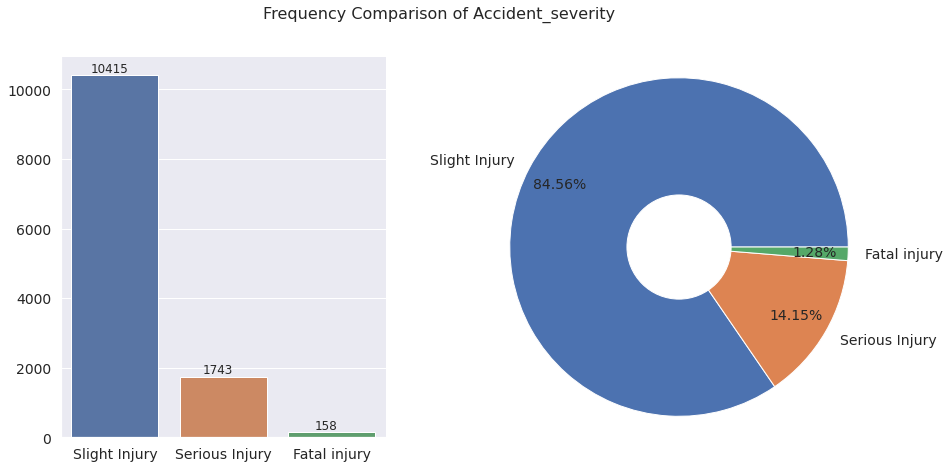

In [20]:
count_donut(data, 'Accident_severity')

The charts show that **the data is imbalanced with respect to the target variable (Accident_severity)**. Note that the percentage values in the pie chart is rounded off to two decimal places and hence may not add up to exactly $100\%$. The class of accidents with slight injury is the majority class with $84.56\%$ of the instances falling in that category. The class of accidents with serious injury comes next with a proportion of $14.15\%$. The class of accidents with fatal injury contributes only $1.28\%$ of the entirety of the dataset. Next we explore various feature variables in the dataset with a particular goal of identifying how the target variable behaves in relation to variation in these features.

### Time

To examine the distribution of time, we convert the feature from $hh:mm:ss$ format to seconds with the mapping

<h2><center> $hh:mm:ss \to (hh \times 60 \times 60)+(mm \times 60)+ss$. </center></h2>

In [21]:
# Convertion of time from hh:mm:ss format to seconds
def convert_to_seconds(x):
    h = int(x.split(':')[0])
    m = int(x.split(':')[1])
    s = int(x.split(':')[2])
    return (h*60*60)+(m*60)+s

data['Time'] = data['Time'].apply(convert_to_seconds)

Under this mapping, the range of time is $0$ to $86400$. We show the convertion for five specific, equispaced time points (the first and last of which are $24$ hours apart, but coincides in the cyclic scale).
- $00:00:00 \to 0$ ($12$ a.m.)
- $06:00:00 \to 21600$ ($6$ a.m.)
- $12:00:00 \to 43200$ ($12$ p.m.)
- $18:00:00 \to 64800$ ($6$ p.m.)
- $24:00:00 \to 86400$ (next day $12$ a.m.)

In the histogram, each bin denotes one-hour time interval, starting from $12$ a.m. We convert the time labels back to the usual notation with a.m. and p.m. for better understanding of the distribution.

In [22]:
data_slight = data[data['Accident_severity'] == 'Slight Injury']
data_serious = data[data['Accident_severity'] == 'Serious Injury']
data_fatal = data[data['Accident_severity'] == 'Fatal injury']

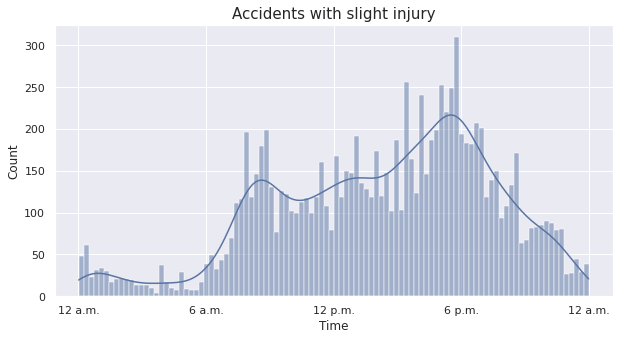

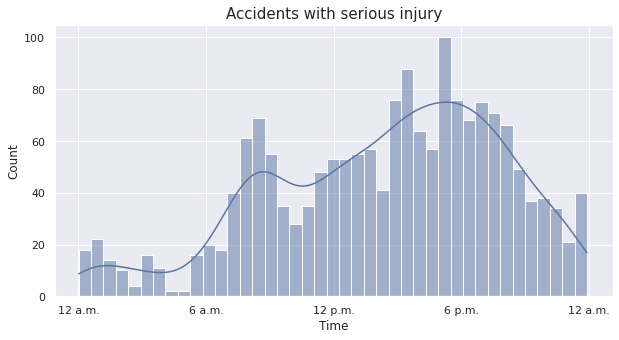

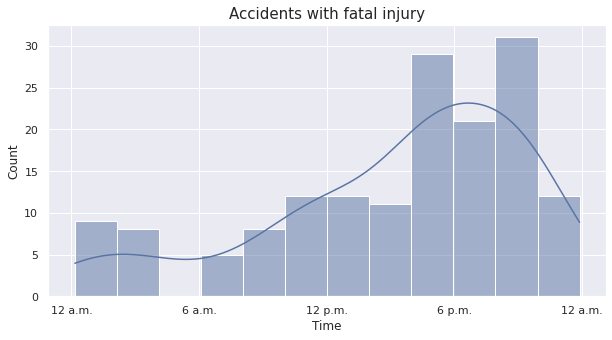

In [23]:
for df in [data_slight, data_serious, data_fatal]:
    plt.figure(figsize = (10, 5))
    nbin = int(np.sqrt(len(df)))
    hist = sns.histplot(df, x = 'Time', color = '#5975a4', kde = 'True', bins = nbin)
    if len(df) == len(data_slight):
        hist.set_title("Accidents with slight injury", fontsize = 15)
    elif len(df) == len(data_serious):
        hist.set_title("Accidents with serious injury", fontsize = 15)
    else:
        hist.set_title("Accidents with fatal injury", fontsize = 15)
    hist.set_xlim(-4000, 90400)
    hist.set_xticks(np.arange(0, 86500, 21600))
    hist.set_xticklabels(['12 a.m.', '6 a.m.', '12 p.m.', '6 p.m.', '12 a.m.'])
    plt.xlabel("Time")
    plt.show()
    print("")

The distribution reflects the intuition that there are more traffic accidents in the day time than at night. In particular, for accidents with slight or serious injuries, the distribution appears to have a bimodal structure with a distinct local mode apart from the global mode. It rises sharply from **5 a.m. - 6 a.m.** until it reaches the local peak at **8 a.m. - 9 a.m.**. After troughing slightly, it gradually rises to the global modal class **5 p.m. - 6 p.m.** Then it falls sharply before stabilizing around **12 a.m. - 1 a.m.** and stays low until **5 a.m. - 6 a.m.**. For accidents with fatal injuries, however, the distribution appears to be slightly different from the former two cases, with a global peak in **8 p.m. - 10 p.m.** and a separate local peak in **4 p.m. - 6 p.m.**

### Other features

In [24]:
# Variables except 'Accident_severity' and 'Time'
features_others = [x for x in data.columns.tolist() if x not in ['Accident_severity', 'Time']]

# List of features with horizontal xtickmarks (for others we shall make it vertical for visualization convenience)
features_horiz = ['Sex_of_driver', 'Vehicle_driver_relation', 'Defect_of_vehicle', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Sex_of_casualty', 'Casualty_severity']

<Figure size 720x360 with 0 Axes>

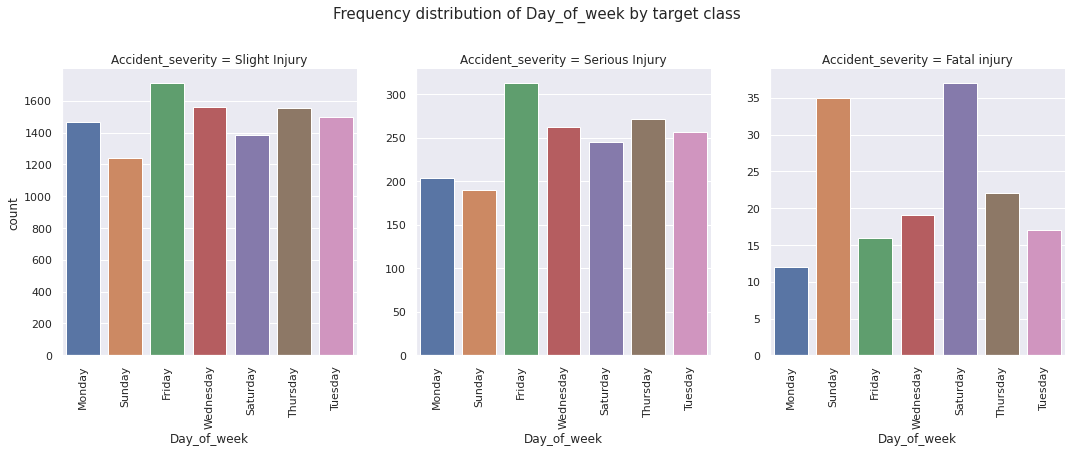

<Figure size 720x360 with 0 Axes>

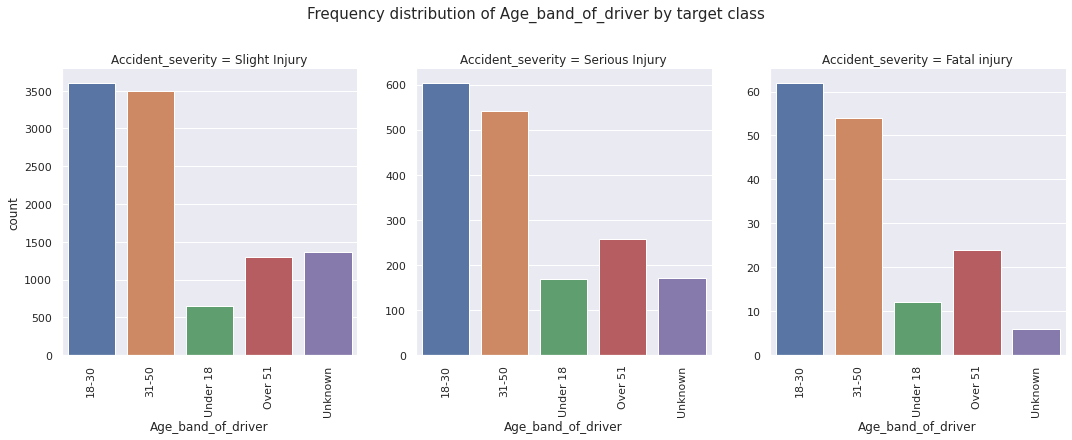

<Figure size 720x360 with 0 Axes>

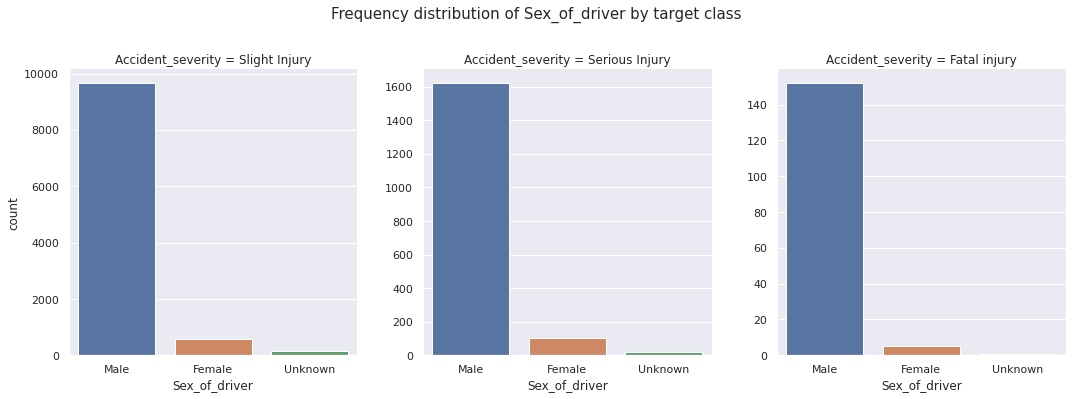

<Figure size 720x360 with 0 Axes>

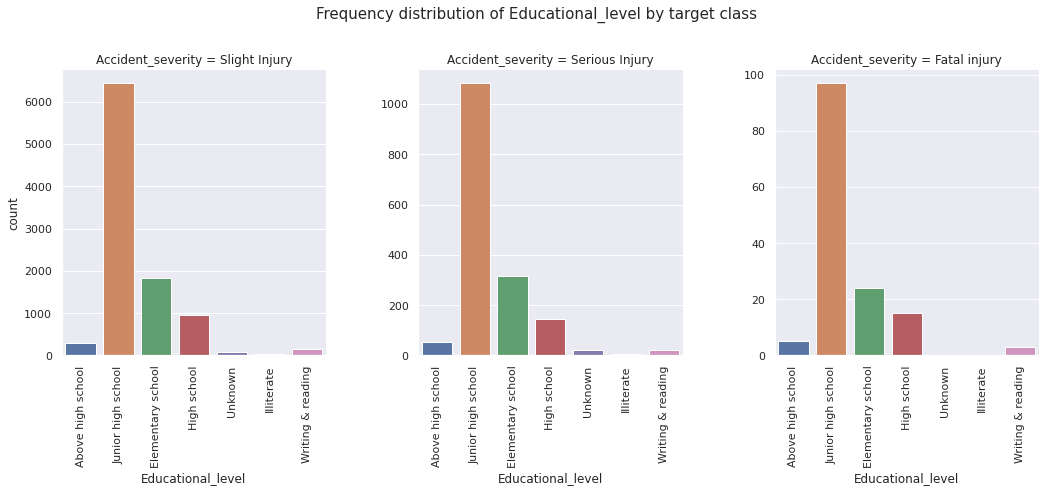

<Figure size 720x360 with 0 Axes>

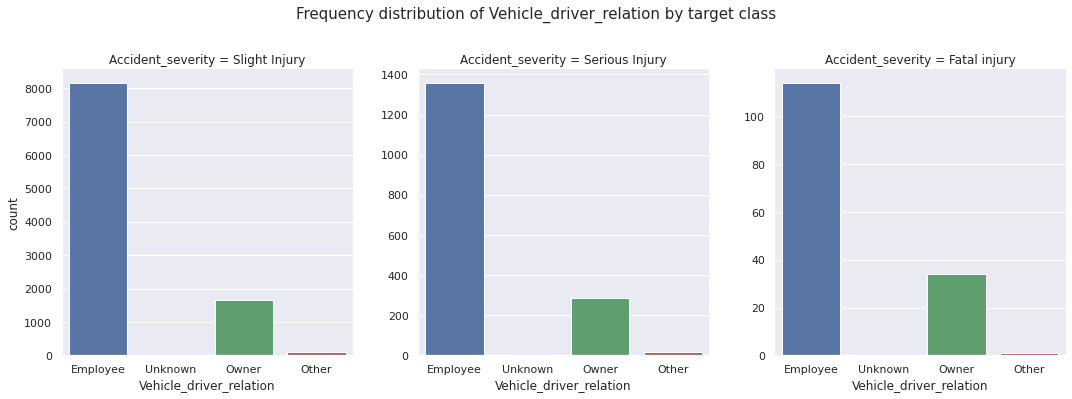

<Figure size 720x360 with 0 Axes>

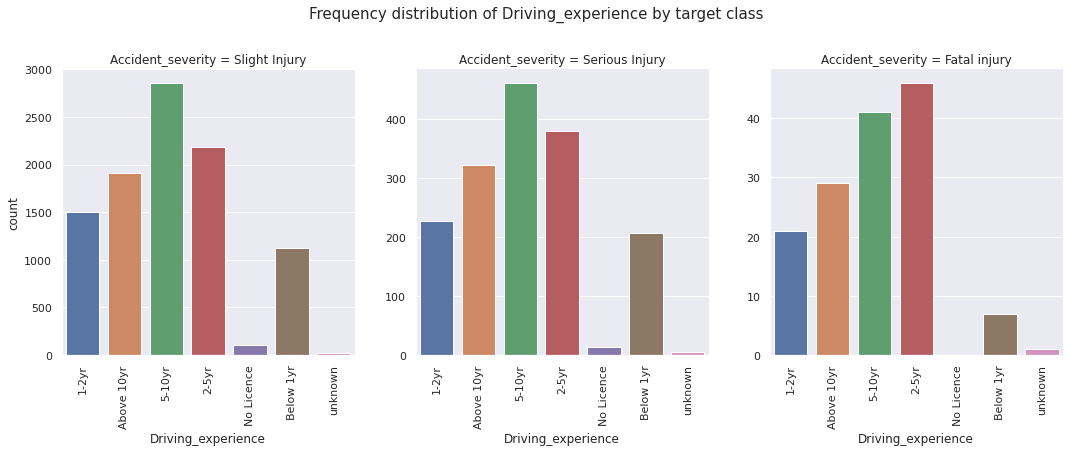

<Figure size 720x360 with 0 Axes>

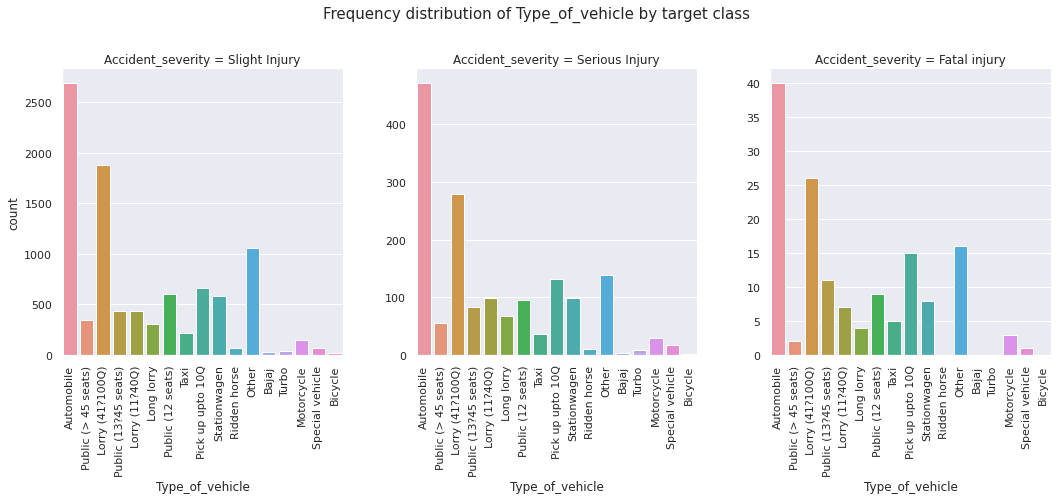

<Figure size 720x360 with 0 Axes>

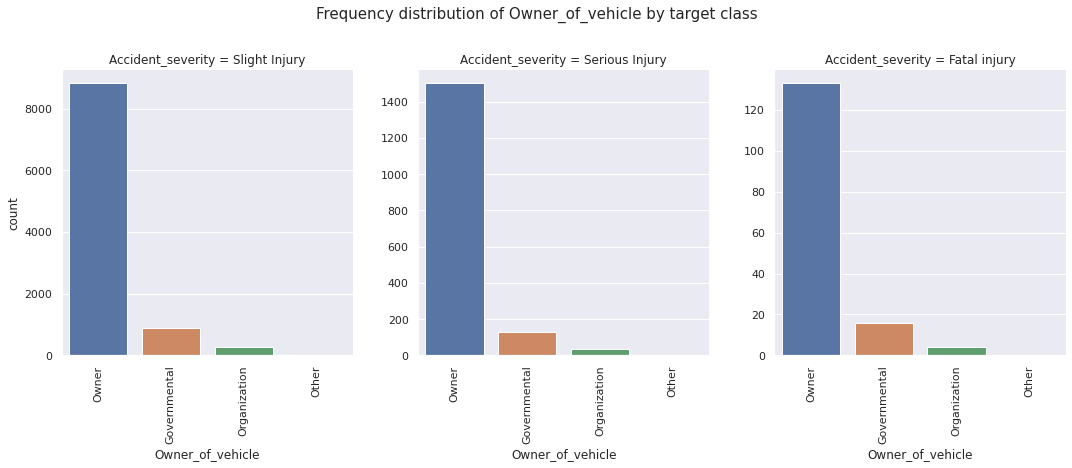

<Figure size 720x360 with 0 Axes>

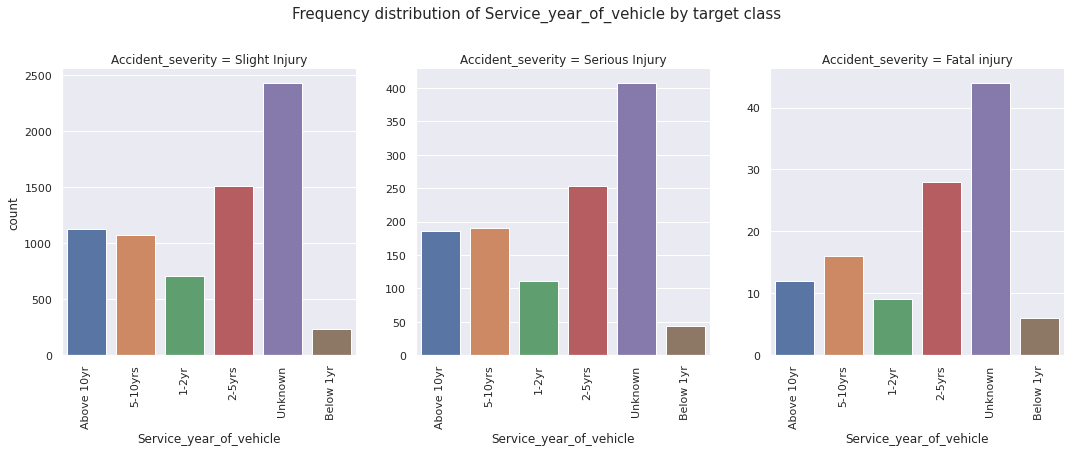

<Figure size 720x360 with 0 Axes>

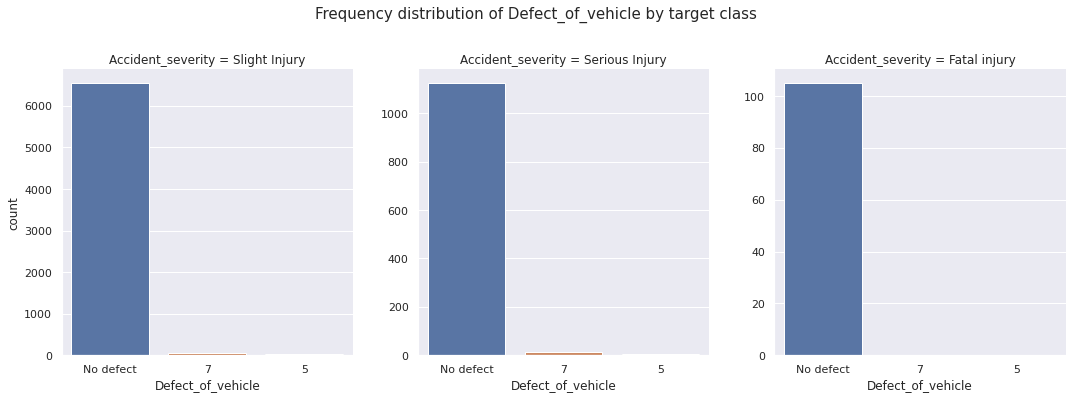

<Figure size 720x360 with 0 Axes>

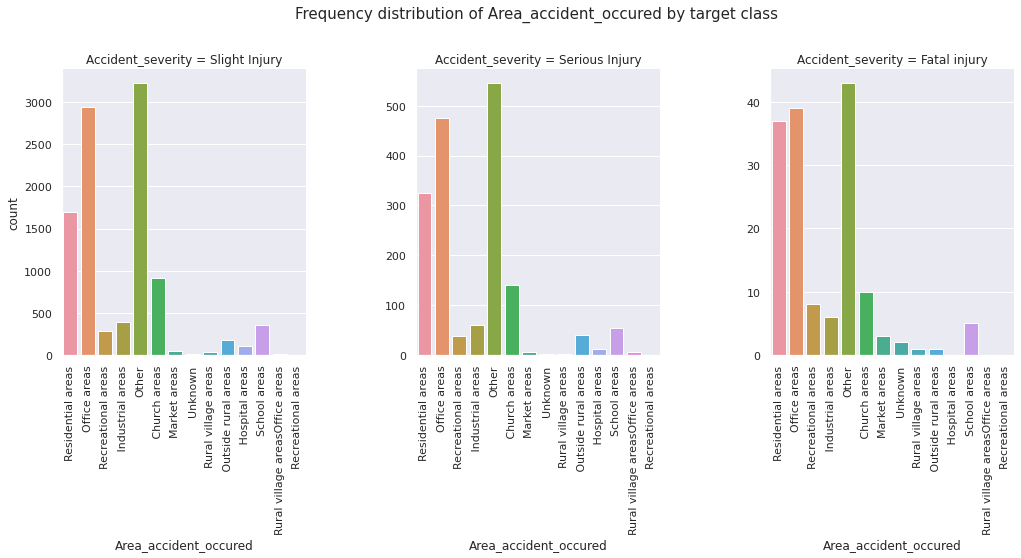

<Figure size 720x360 with 0 Axes>

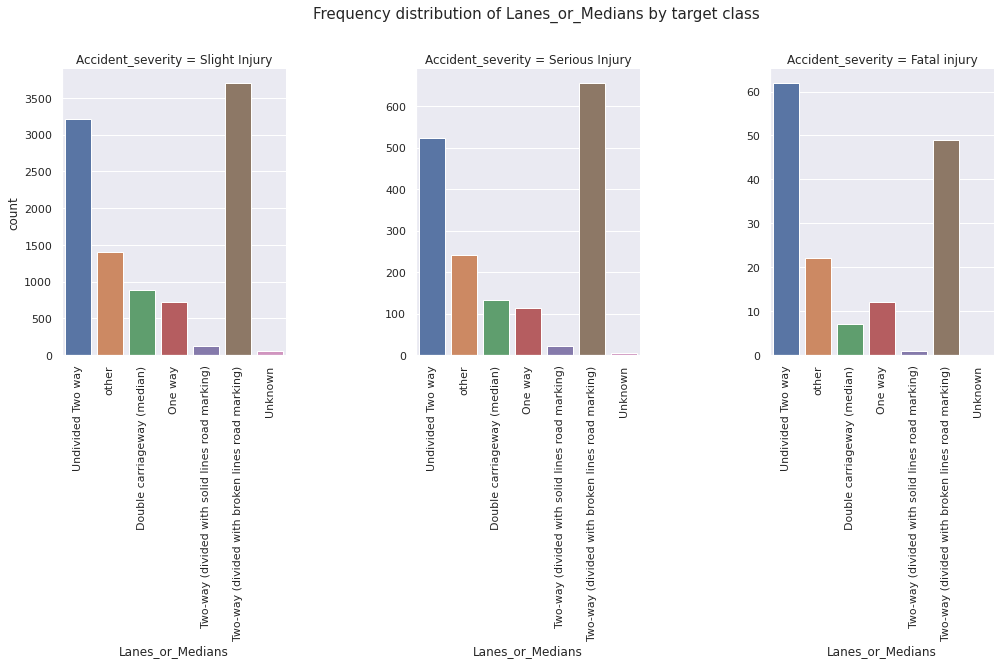

<Figure size 720x360 with 0 Axes>

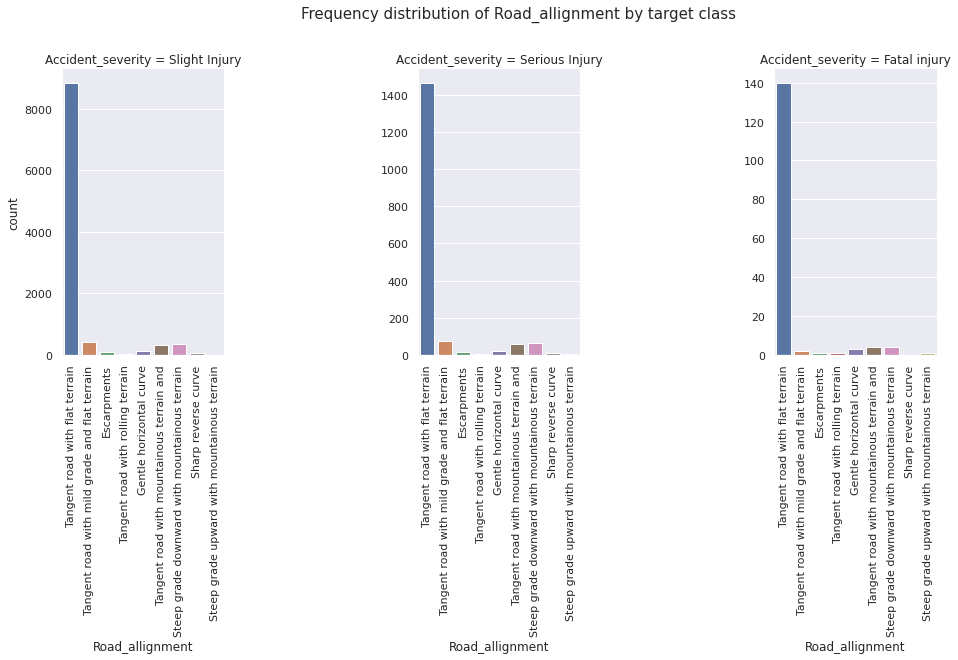

<Figure size 720x360 with 0 Axes>

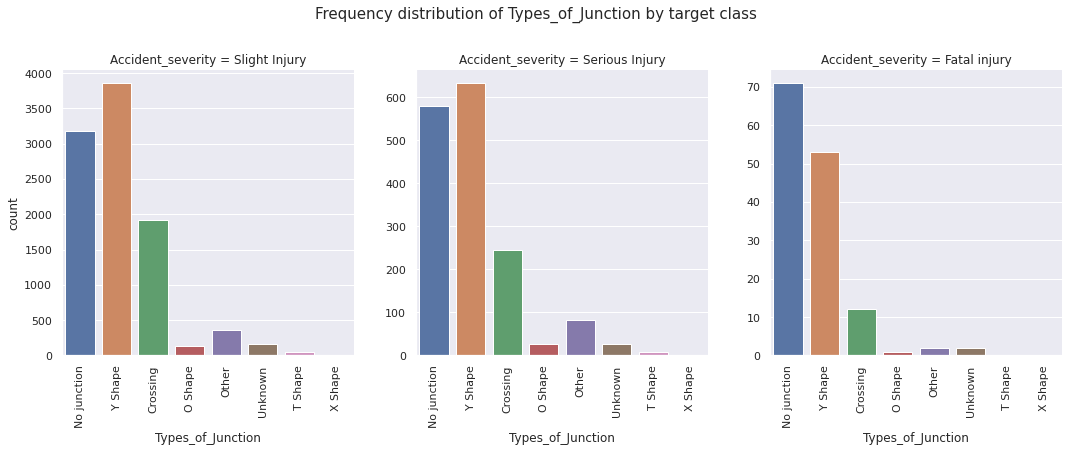

<Figure size 720x360 with 0 Axes>

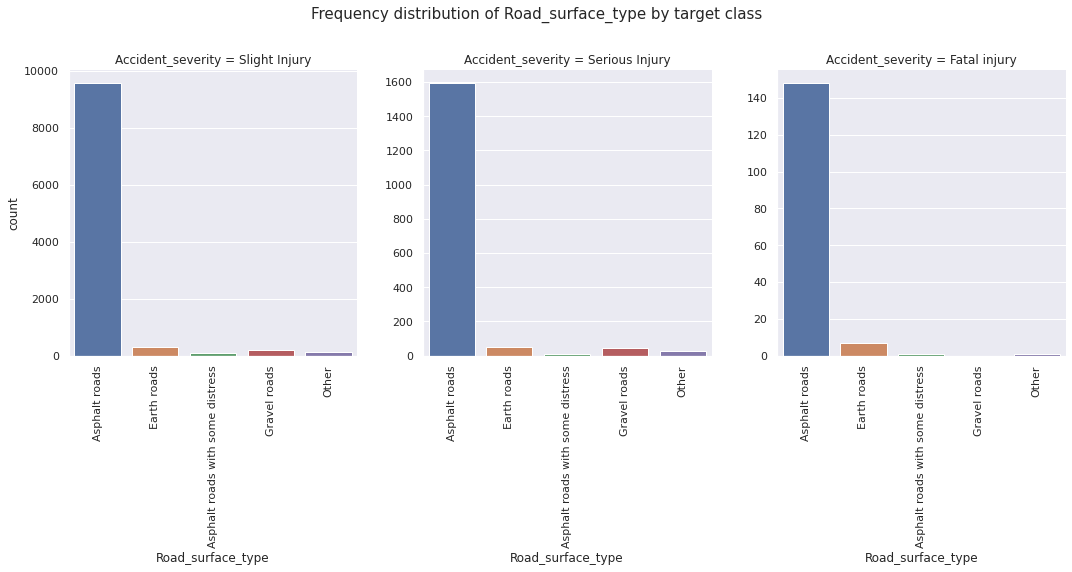

<Figure size 720x360 with 0 Axes>

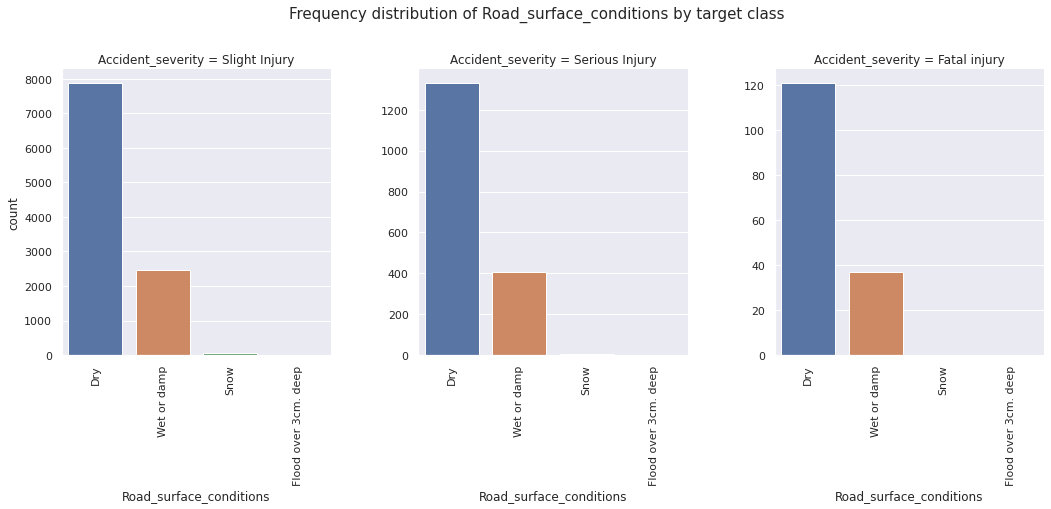

<Figure size 720x360 with 0 Axes>

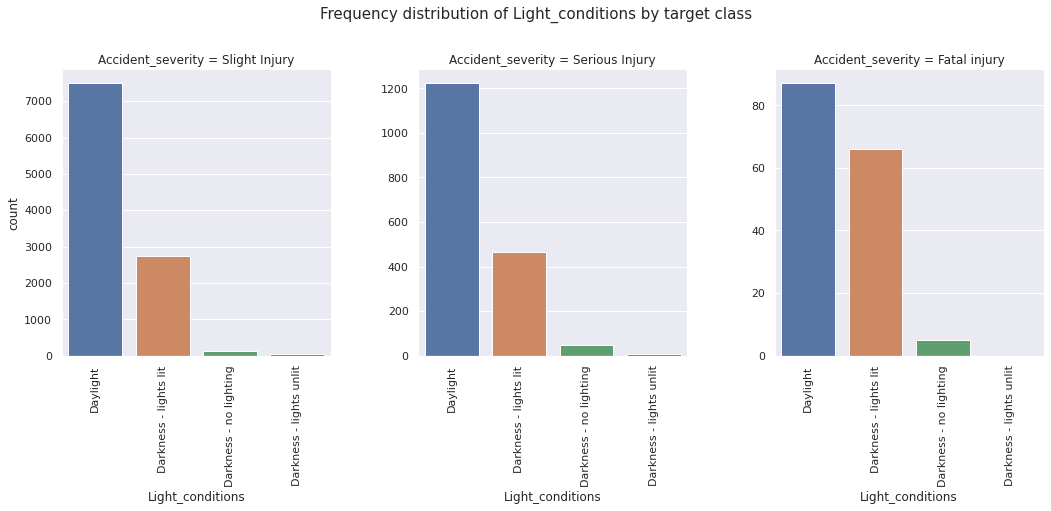

<Figure size 720x360 with 0 Axes>

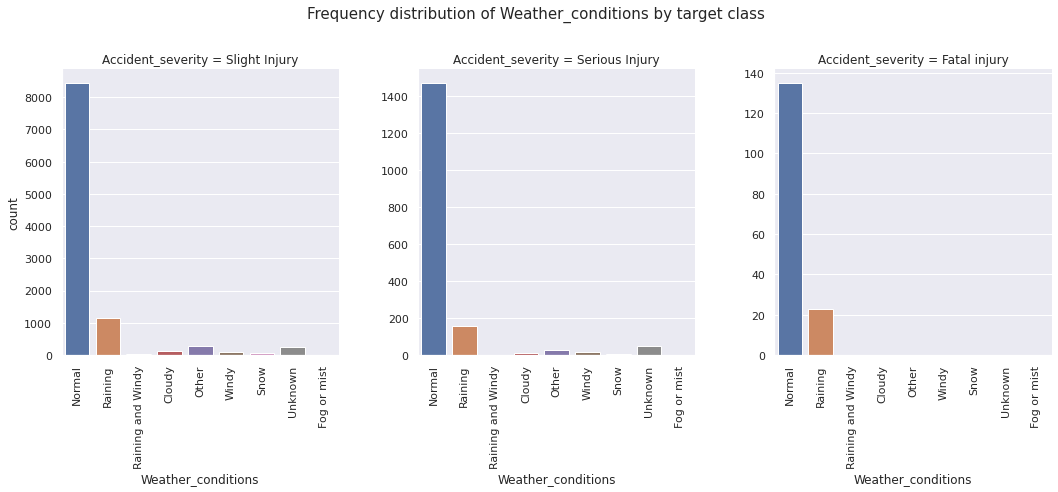

<Figure size 720x360 with 0 Axes>

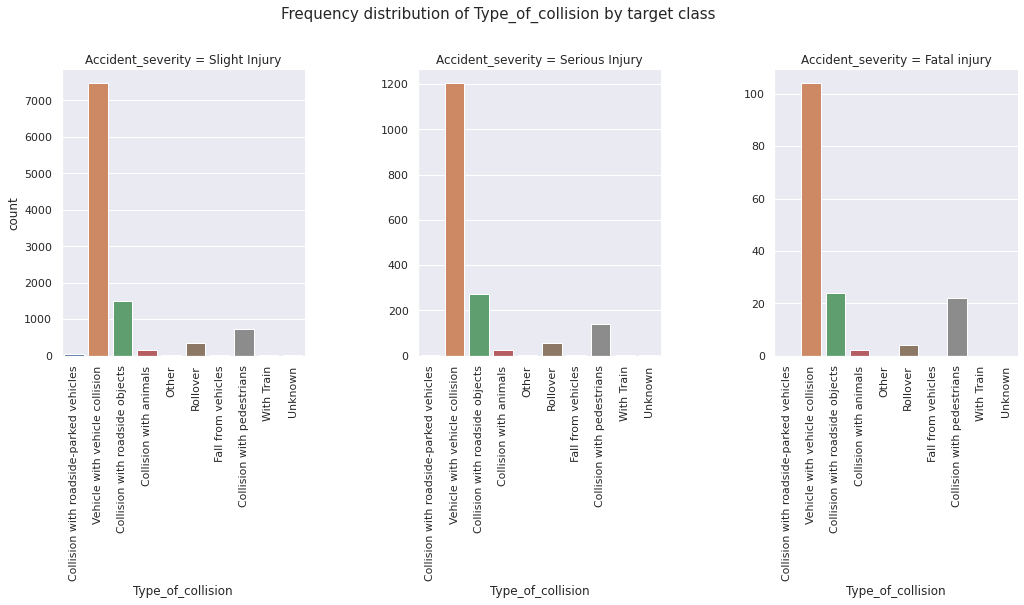

<Figure size 720x360 with 0 Axes>

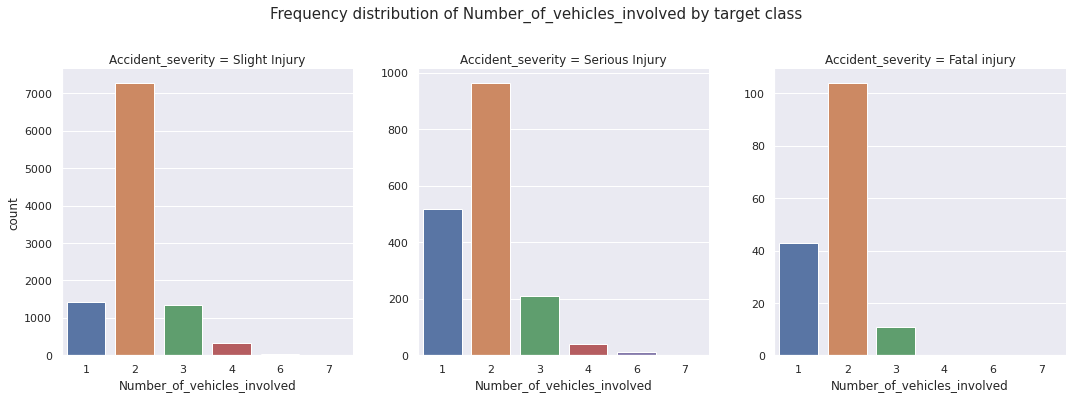

<Figure size 720x360 with 0 Axes>

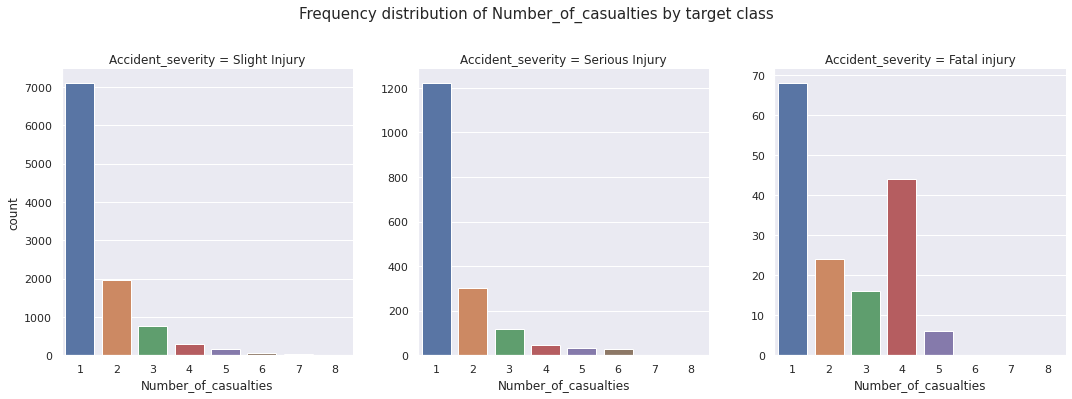

<Figure size 720x360 with 0 Axes>

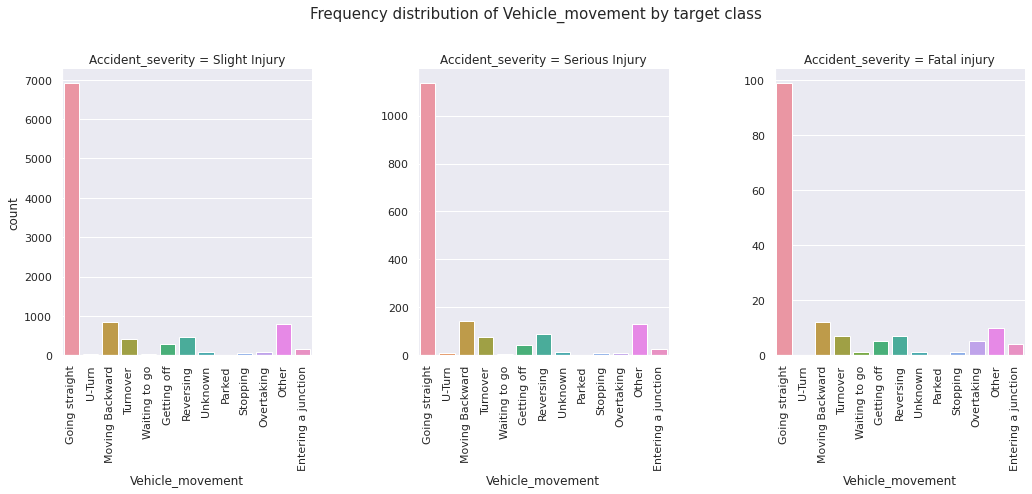

<Figure size 720x360 with 0 Axes>

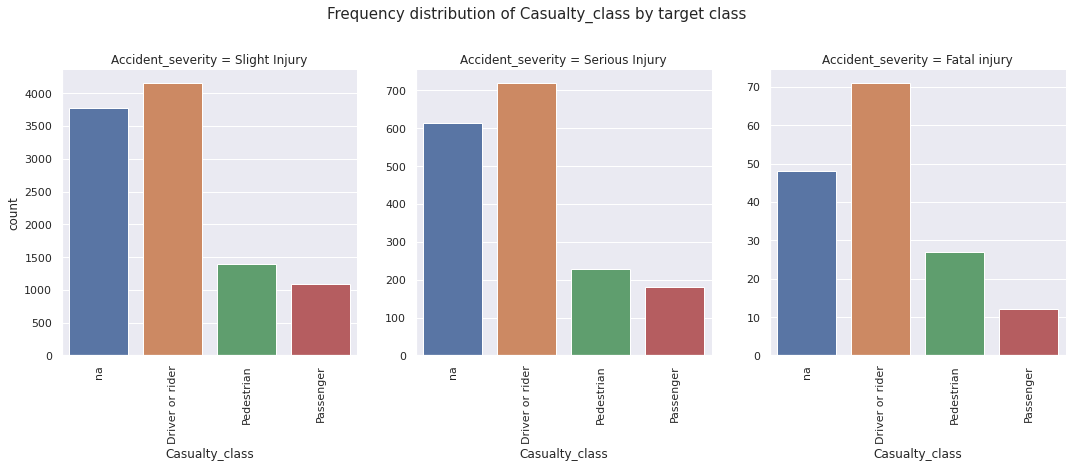

<Figure size 720x360 with 0 Axes>

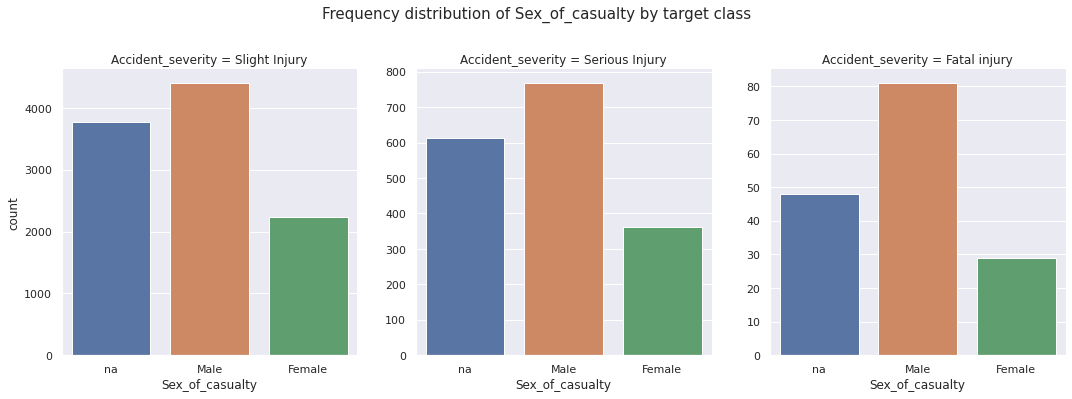

<Figure size 720x360 with 0 Axes>

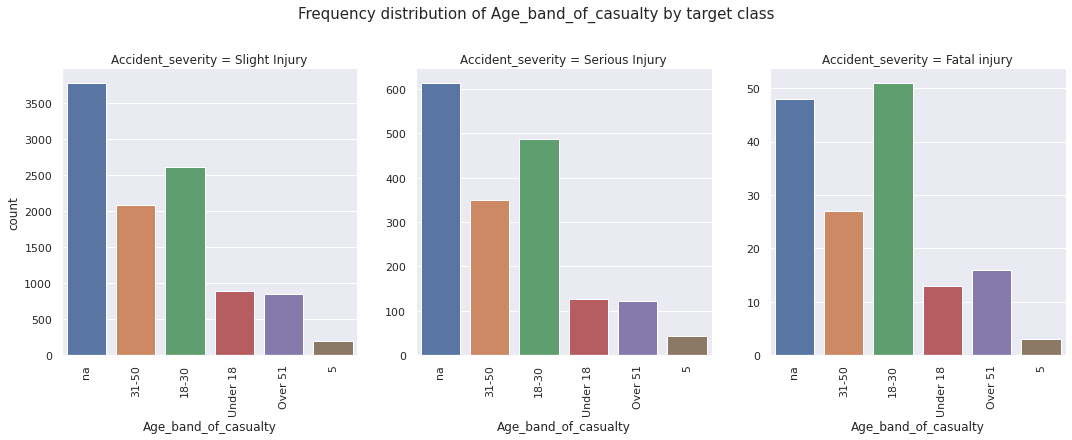

<Figure size 720x360 with 0 Axes>

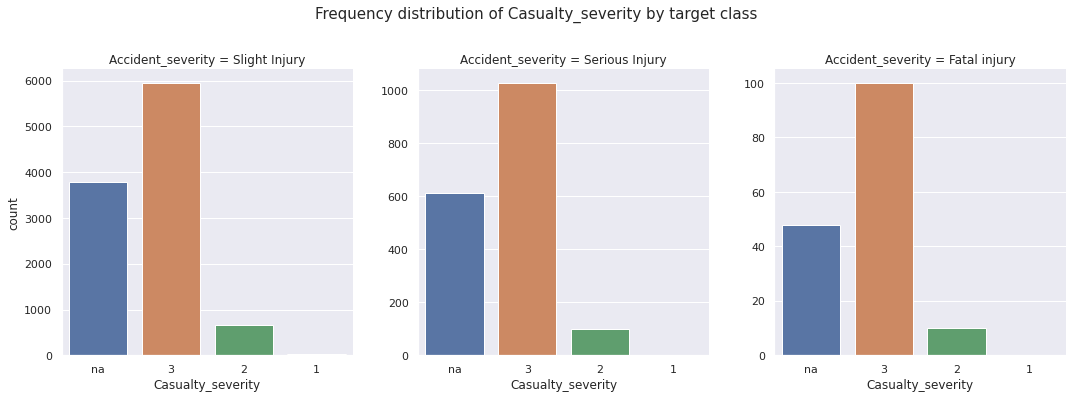

<Figure size 720x360 with 0 Axes>

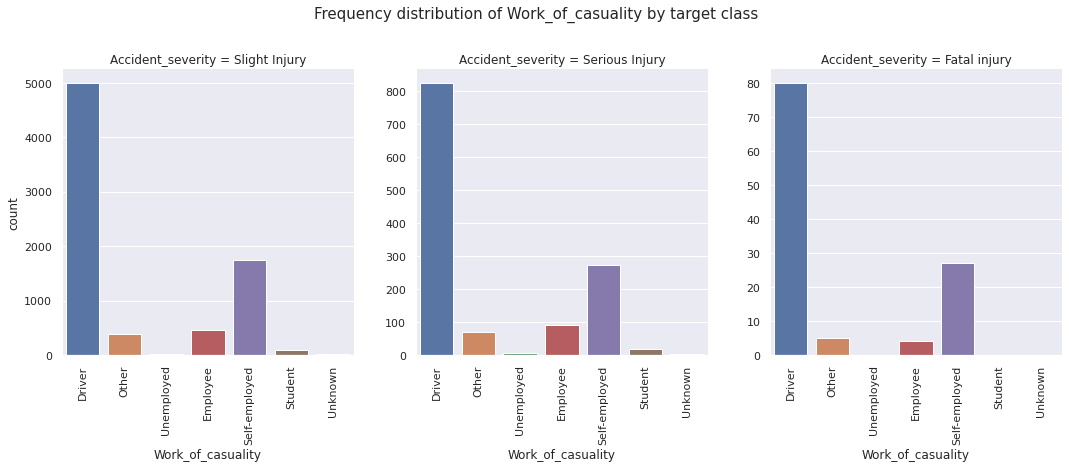

<Figure size 720x360 with 0 Axes>

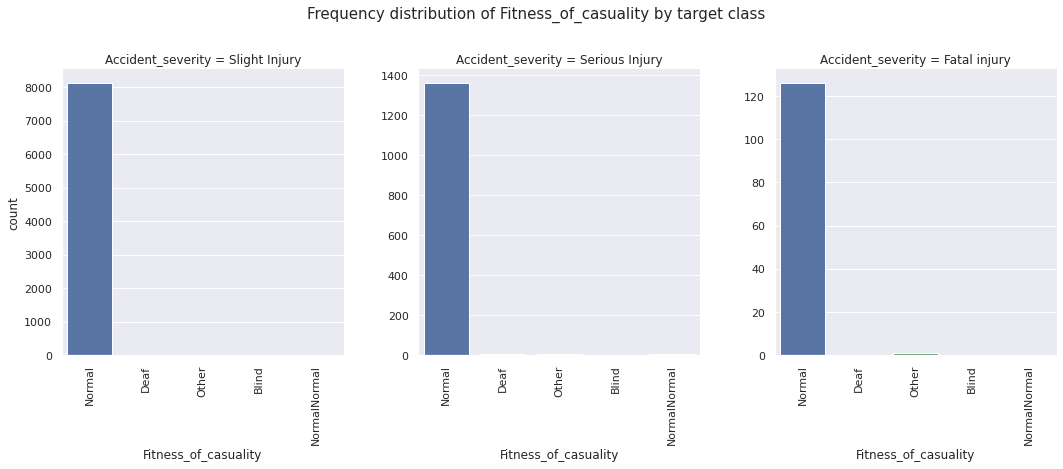

<Figure size 720x360 with 0 Axes>

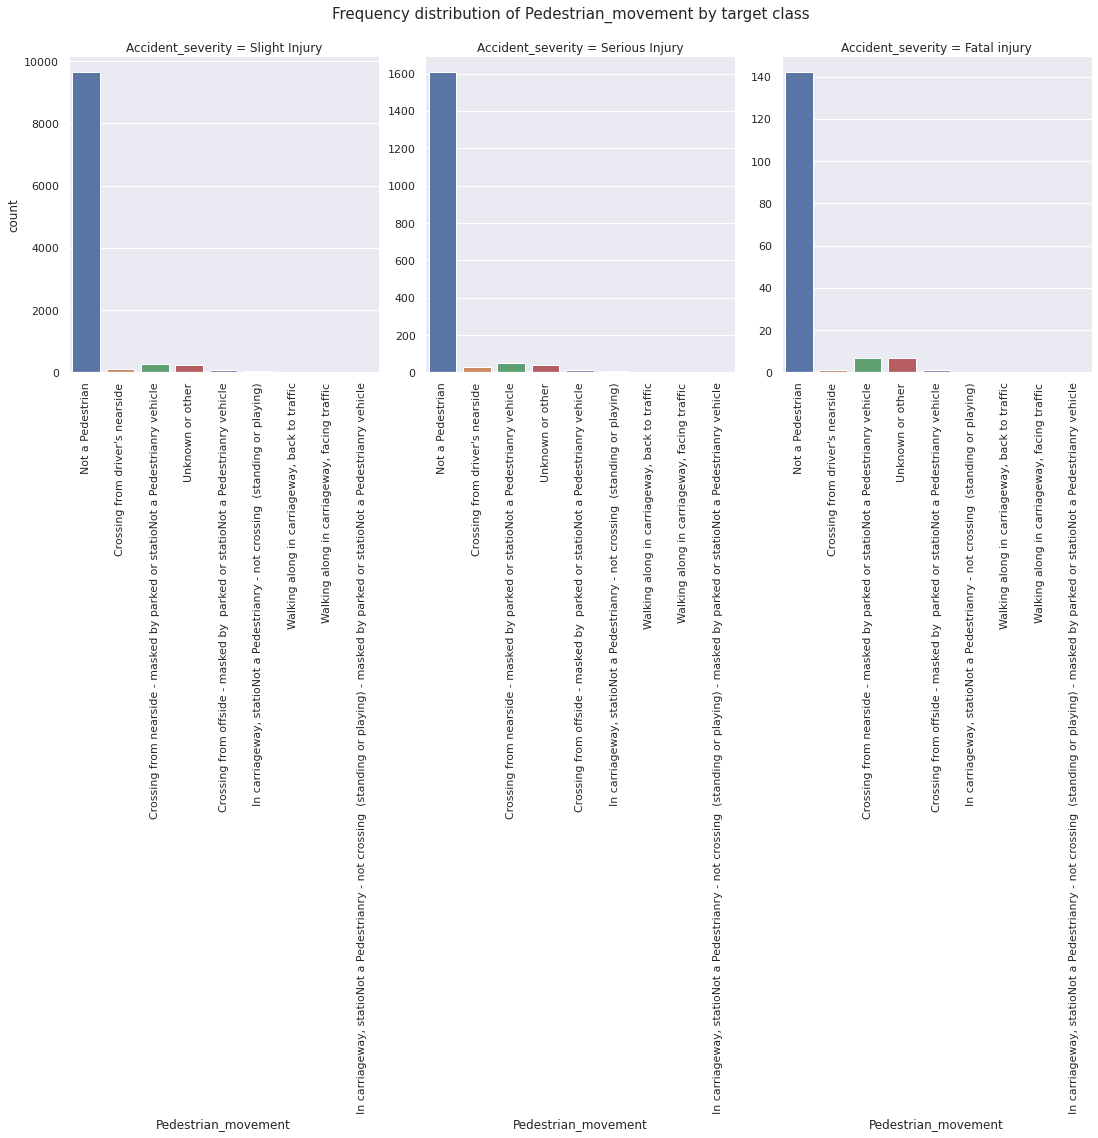

<Figure size 720x360 with 0 Axes>

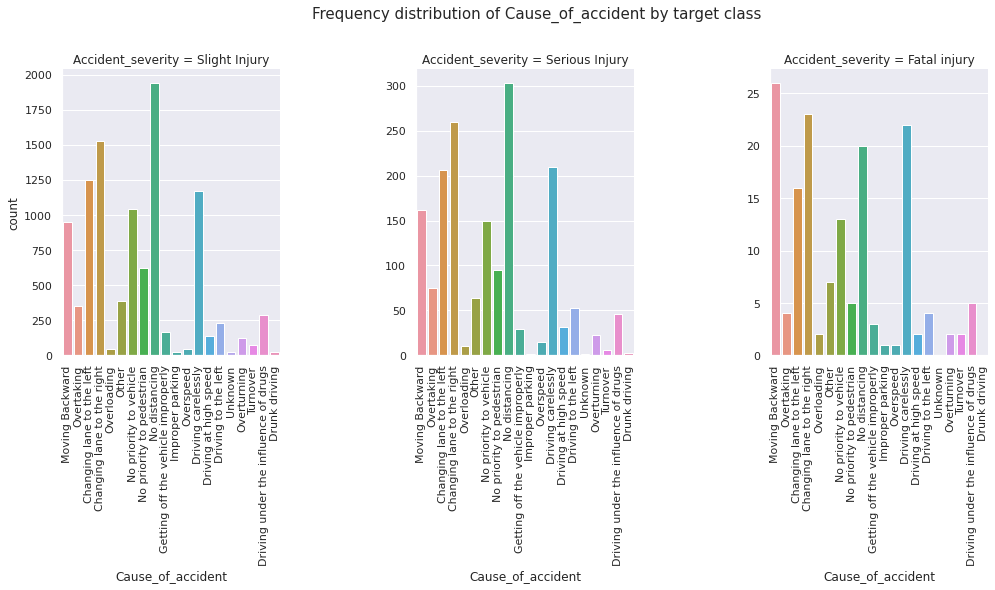

In [25]:
# Catplot to compare frequency distributions of features (except 'Time') across target classes
for feature in features_others:
    plt.figure(figsize = (10, 5))
    catplot = sns.catplot(data = data, x = feature, col = 'Accident_severity', kind = 'count', sharey = False)
    if feature not in features_horiz:
        catplot.set_xticklabels(rotation = 90)
    plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
    plt.show()

We denote:
- **target class 1 $\to$ class of accidents with slight injury**
- **target class 2 $\to$ class of accidents with serious injury**
- **target class 3 $\to$ class of accidents with fatal injury**

Then we observe:
- **Features that have more or less similar distribution for all target classes:** Sex_of_driver, Educational_level, Vehicle_driver_relation, Owner_of_vehicle, Defect_of_vehicle, Road_surface_type, Road_surface_conditions, Light_conditions, Weather_conditions, Vehicle_movement, Sex_of_casualty, Casualty_severity, Fitness of Casuality, Pedestrian_movement
- **Features that have more or less similar distribution for target class 1 and target class 2, but have a different distribution for target class 3:** Time, Day_of_week, Driving_experience, Service_year_of_vehicle, Area_accident_occured, Lanes_or_Medians, Road_allignment, Types_of_Junction, Type_of_collision, Number_of_casualties, Casualty_class, Age_band_of_casualty, Work_of_casuality, Cause_of_accident
- **Features that have more or less similar distribution for target class 2 and target class 3, but have a different distribution for target class 1:** Number_of_vehicles_involved
- **Features that have different distributions for all target class:** Age_band_of_driver, Type_of_vehicle

# 3. Data Preprocessing

## 3.1. Outlier Detection

There are three numerical variables in the dataset.
- **Time** is a bounded variable. After the convertion, it is strictly bounded between 0 and 86400. It has a minimum value of 60 and a maximum of 86340. Since we know that the traffic are active round the clock (even with the obvious bias to day-time), we discard the possibility of outliers here.
- **Number_of_vehicles_involved** is a count data, taking positive integer values (as there can be no traffic accident without vehicles).
- **Number_of_casualties** is again a count data, taking positive integer values.

We present the respective boxplots to check for outliers.

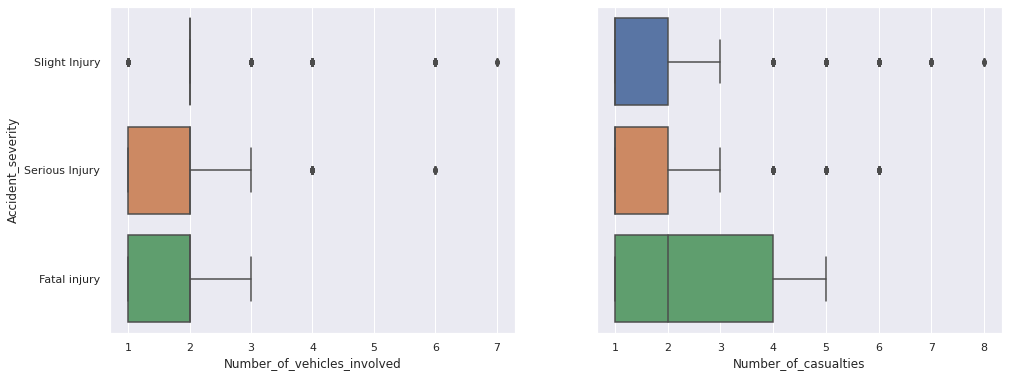

In [26]:
# Boxplots for outlier detection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
sns.boxplot(data = data, x = 'Number_of_vehicles_involved', y = 'Accident_severity', ax = ax1)
sns.boxplot(data = data, x = 'Number_of_casualties', y = 'Accident_severity', ax = ax2).set(yticklabels = [])
ax2.set_ylabel('')
plt.show()

Despite the appearances of the apparent outliers, **we refrain from deleting or modifying** them as it is evident from the range of the variables that these are most likely to be genuine values, containing relevant information about the corresponding variables.

## 3.2. Missing Data Imputation

In [27]:
# Combining similar values
def combine_similar(data):
    data = data.replace('Unknown', 'unknown')
    data = data.replace('Other', 'other')
    data = data.replace('Unknown or other', 'other')
    data = data.replace('Darkness - lights unlit', 'Darkness - no lighting')
    data['Age_band_of_casualty'] = data['Age_band_of_casualty'].replace('5', 'Under 18')
    return data

In [28]:
data = combine_similar(data)

In [29]:
# Columns with missing values (sorted by count)
data.isna().sum()[data.isna().sum() != 0].sort_values(ascending = False)

Defect_of_vehicle          4427
Service_year_of_vehicle    3928
Work_of_casuality          3198
Fitness_of_casuality       2635
Type_of_vehicle             950
Types_of_Junction           887
Driving_experience          829
Educational_level           741
Vehicle_driver_relation     579
Owner_of_vehicle            482
Lanes_or_Medians            385
Vehicle_movement            308
Area_accident_occured       239
Road_surface_type           172
Type_of_collision           155
Road_allignment             142
dtype: int64

**Note:** 16 columns (out of 32) contain missing values. All features with missing values are categorical in nature.

In [30]:
# Rows with missing values (sorted by count)
data.T.isna().sum()[data.T.isna().sum() != 0].sort_values(ascending = False)

2035     11
1191     11
1022     11
2204     10
174      10
         ..
5836      1
5809      1
5806      1
5804      1
12312     1
Length: 9427, dtype: int64

**Note:** 9427 rows (out of 12316) contain missing values.

In [31]:
# Converting unknown/other/na to nan
def more_missing(data):
    data = data.replace('unknown', np.nan)
    data = data.replace('other', np.nan)
    data = data.replace('na', np.nan)
    return data

In [32]:
# data = more_missing(data)

### Mode imputation

In [33]:
# Function to impute missing values with the most frequent value appearing in the corresponding columns
def mode_imputer(data):
    data_imputed = data.copy(deep = True)
    imputer = SimpleImputer(strategy = 'most_frequent')
    data_imputed.iloc[:,:] = imputer.fit_transform(data_imputed)
    return data_imputed

### Assigning to 'unknown' category

In [34]:
# Function to assign the missing values to the 'unknown' category
def unknown_imputer(data):
    data_unknown = data.copy(deep = True)
    data_unknown = data_unknown.replace(np.nan, 'unknown')
    return data_unknown

### Proportion-based imputation

With the goal of keeping the feature distributions same before and after imputation, we impute the missing values in a column in such a way so that the proportions of the existing unique values in the column remain roughly same as those were prior to the imputation.

In [35]:
# Function to impute missing values proportionately with respect to the existing unique values
def prop_imputer(data):
    data_prop = data.copy(deep = True)
    missing_cols = data_prop.isna().sum()[data_prop.isna().sum() != 0].index.tolist()
    for col in missing_cols:
        values_col = data_prop[col].value_counts(normalize = True).index.tolist()
        probabilities_col = data_prop[col].value_counts(normalize = True).values.tolist()
        data_prop[col] = data_prop[col].fillna(pd.Series(np.random.choice(values_col, p = probabilities_col, size = len(data))))
    return data_prop

### Frequency distribution before and after imputation

In [36]:
# Imputation
data_imp = prop_imputer(data)

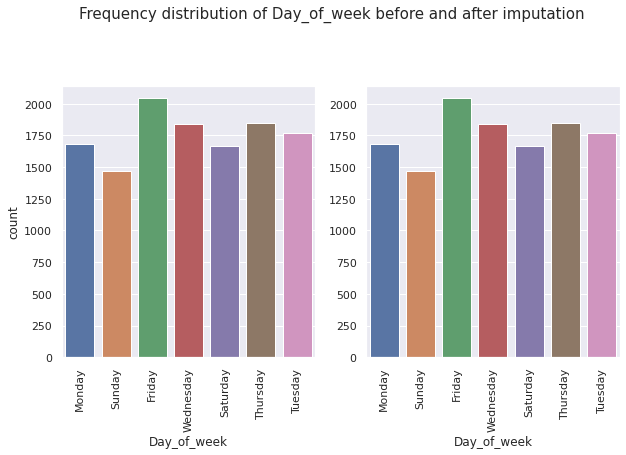

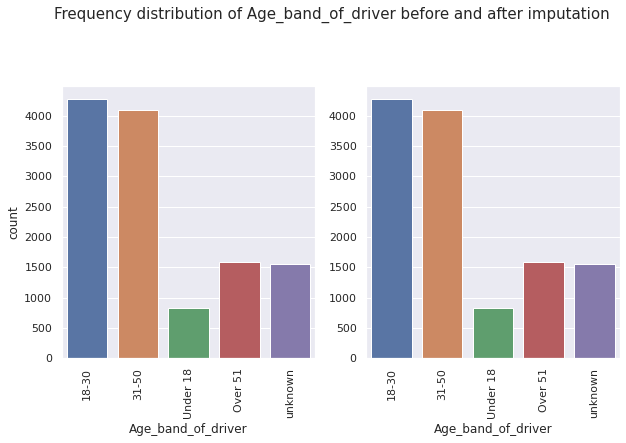

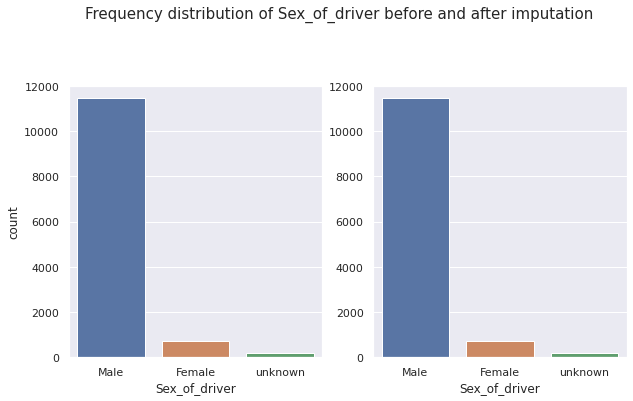

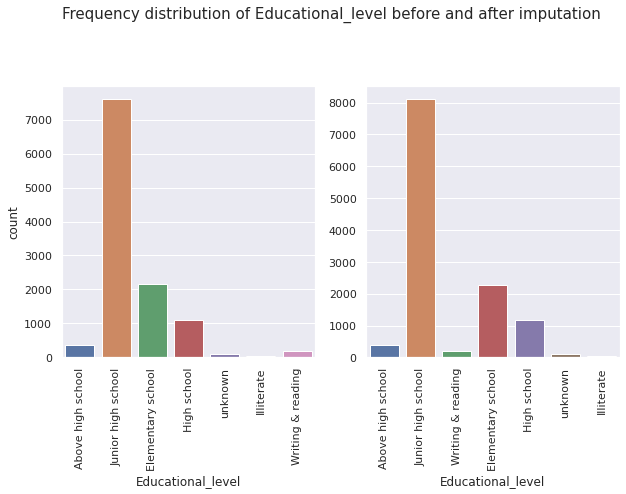

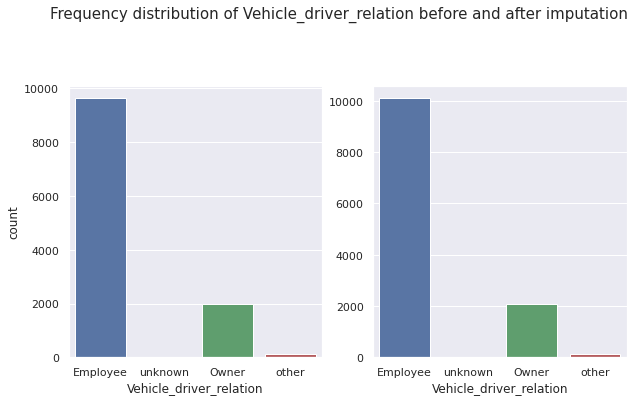

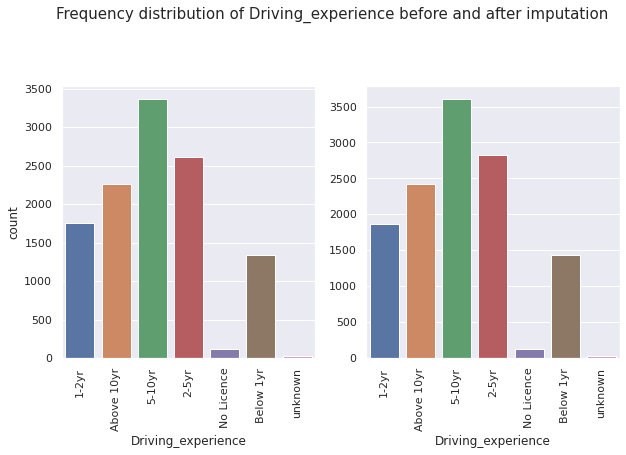

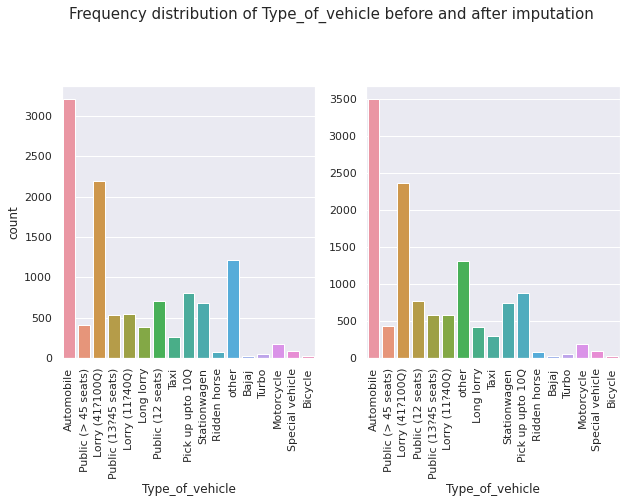

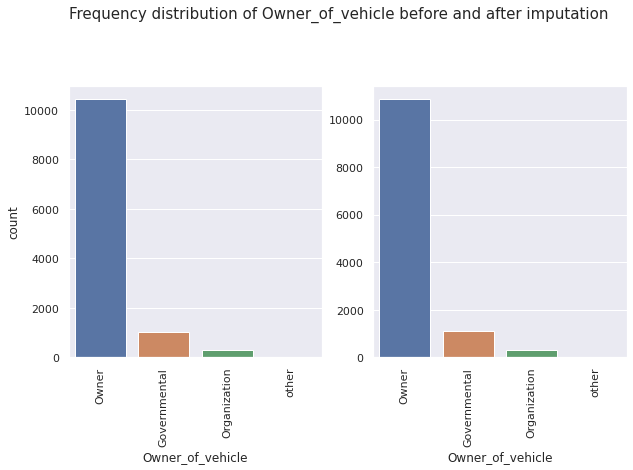

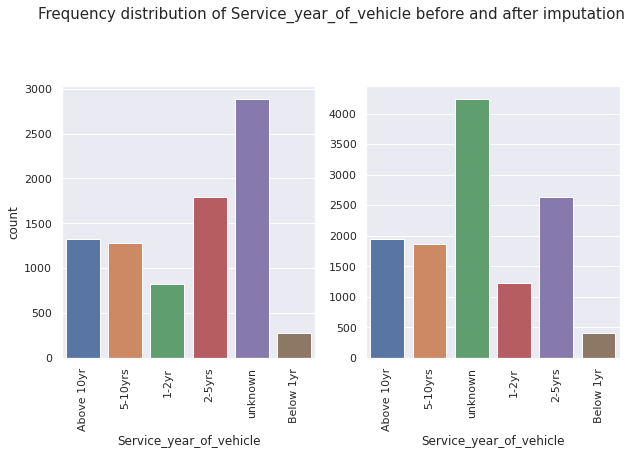

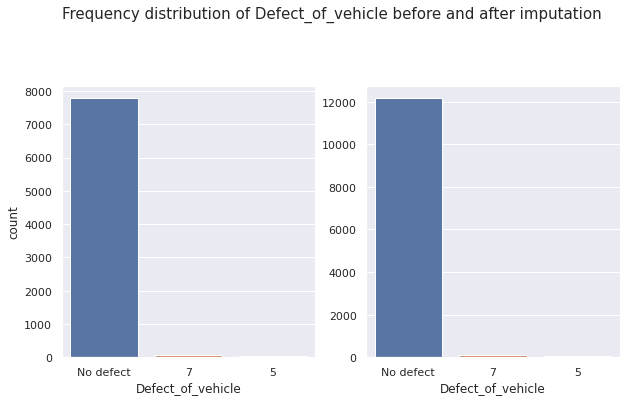

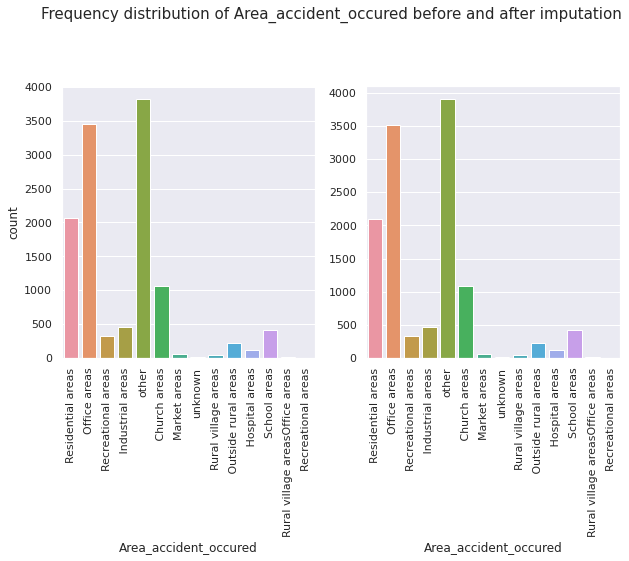

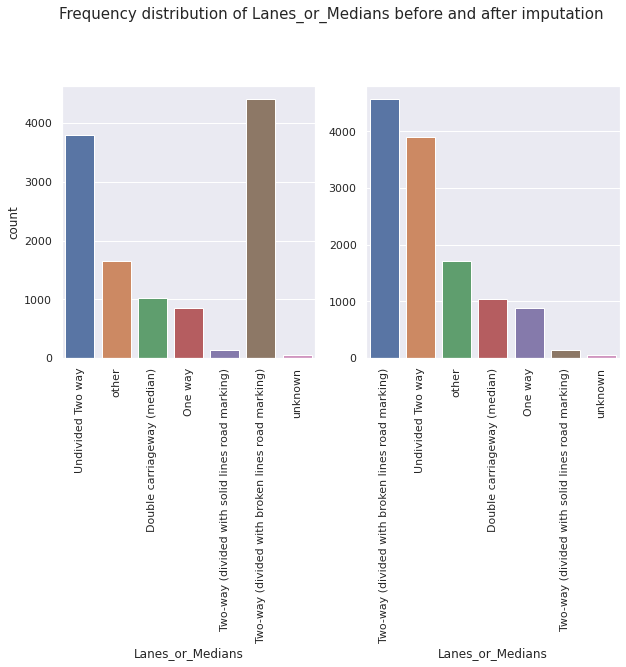

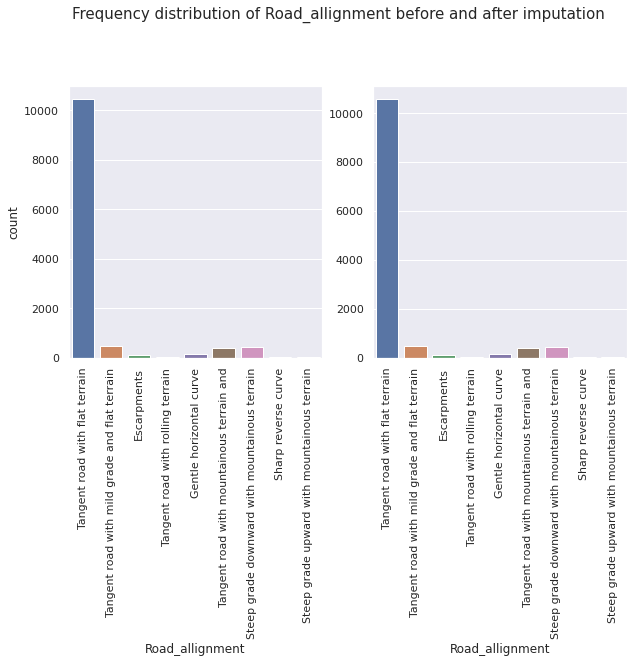

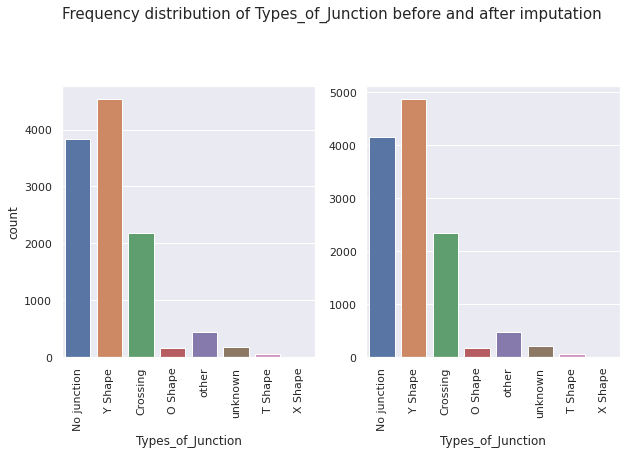

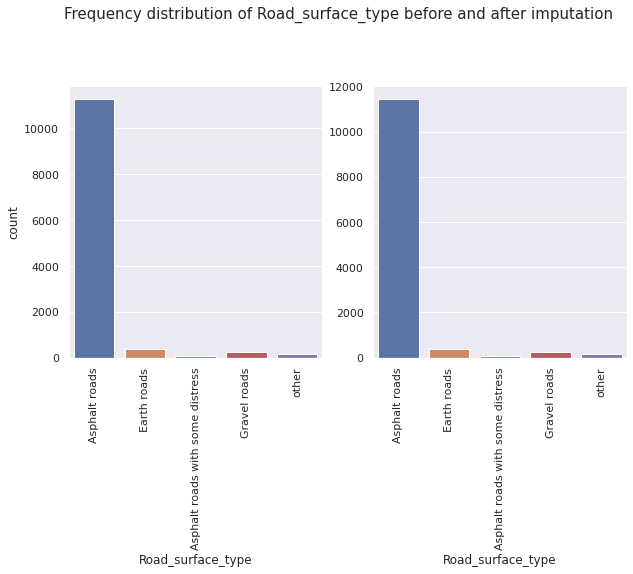

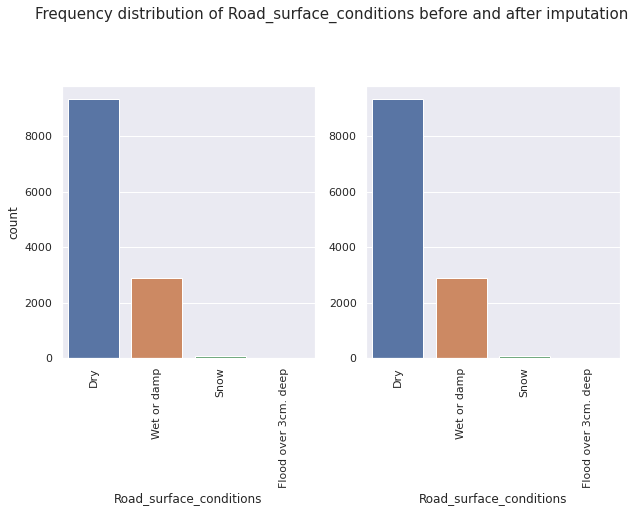

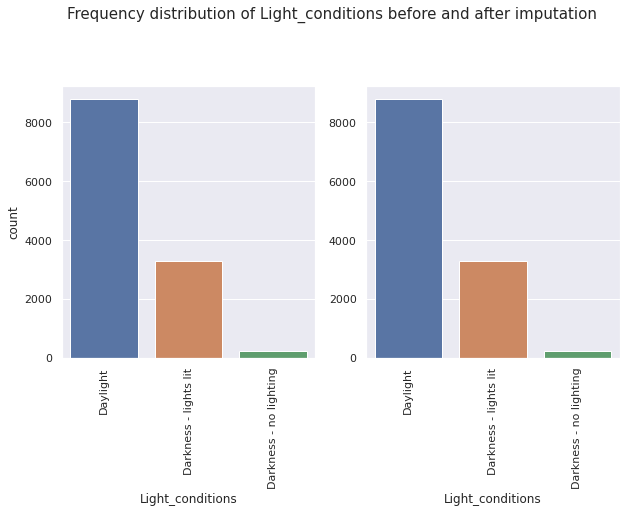

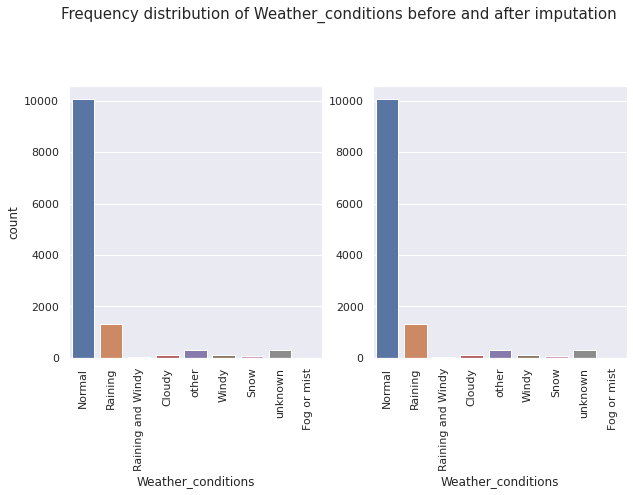

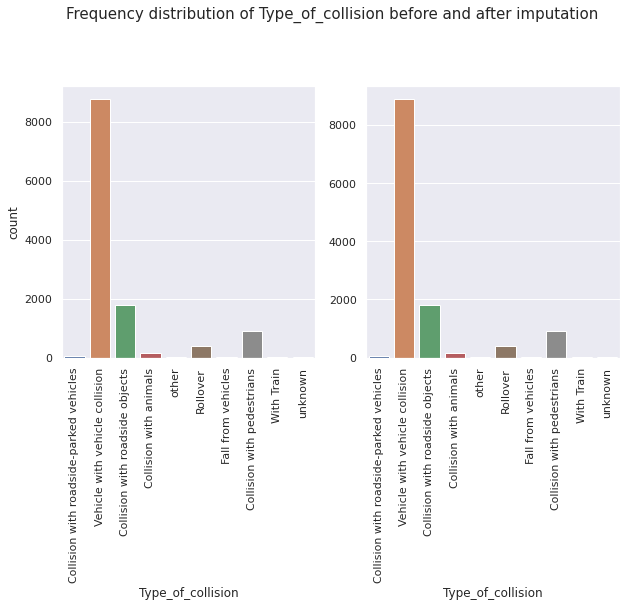

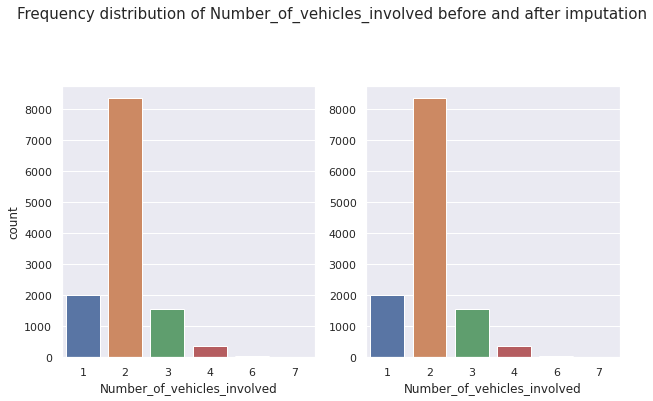

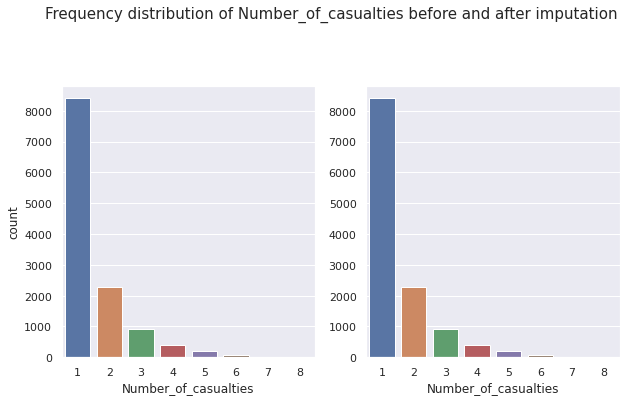

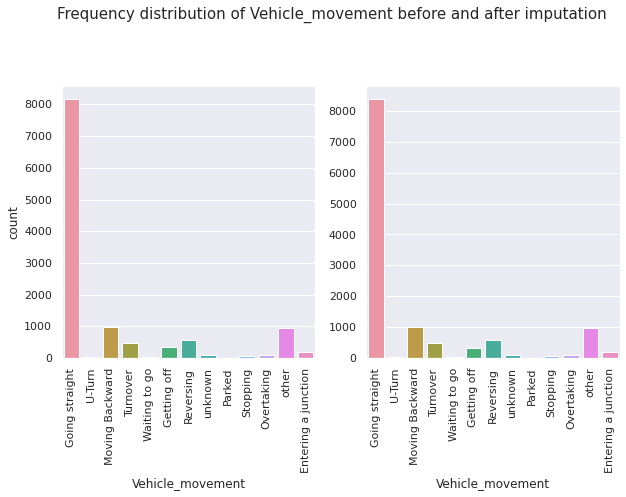

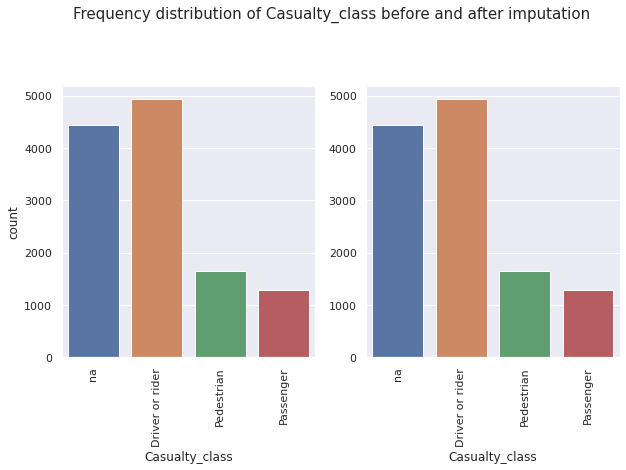

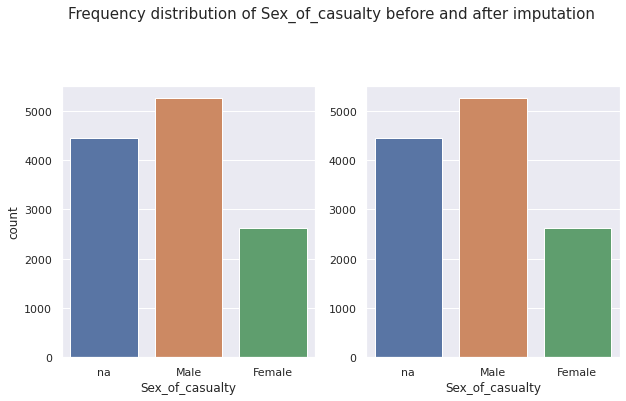

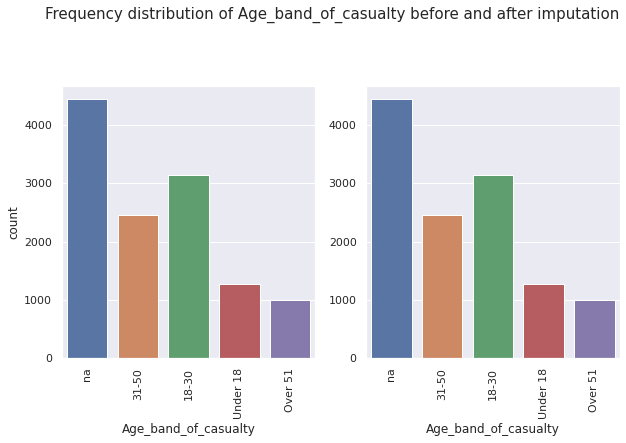

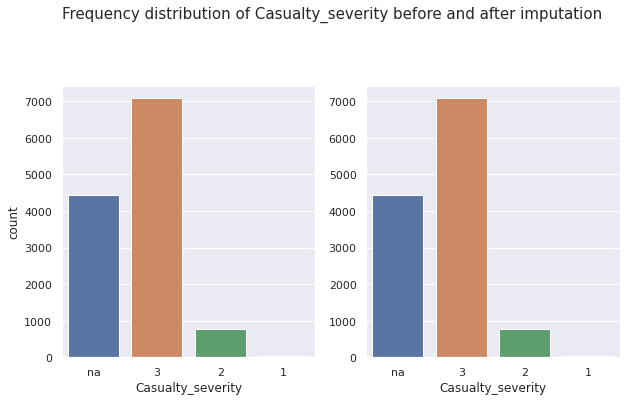

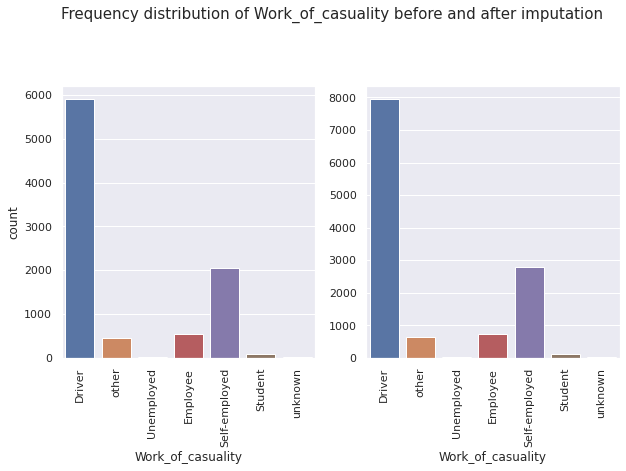

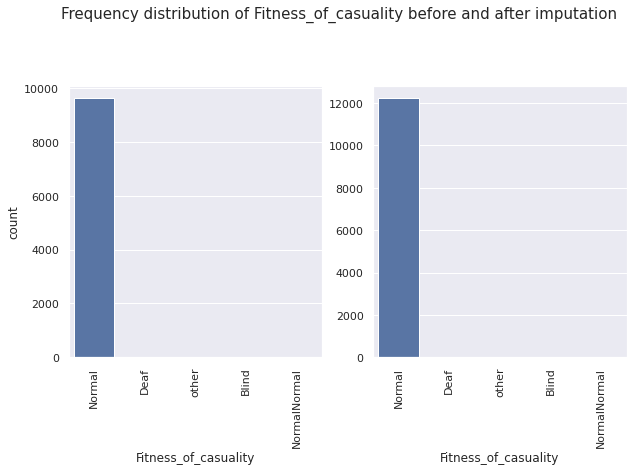

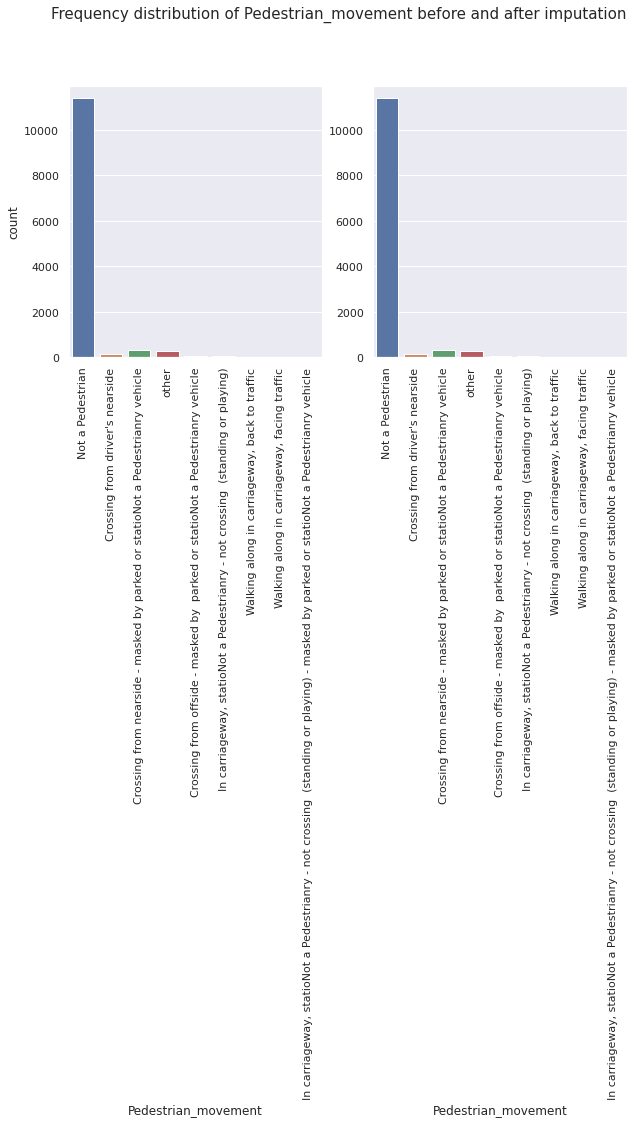

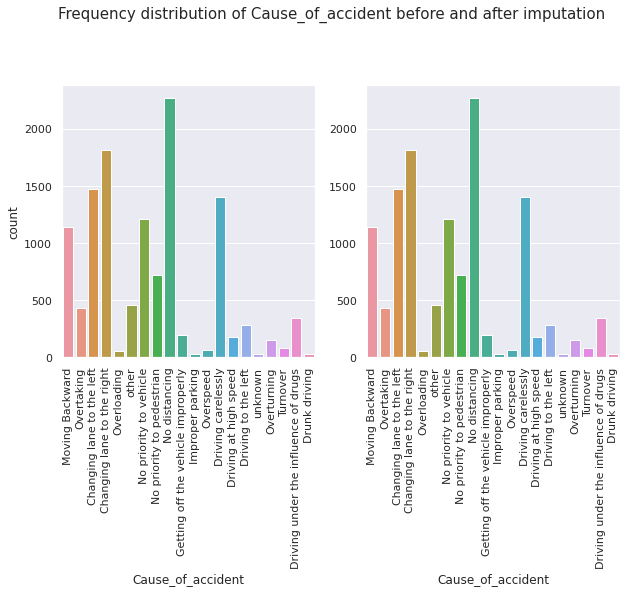

In [37]:
# Comparison of frequency distribution of the features before and after imputation
for feature in features_others:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1 = sns.countplot(data[feature], ax = ax1)
    ax2 = sns.countplot(data_imp[feature], ax = ax2)
    ax2.set_ylabel('')
    if feature not in features_horiz:
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
    plt.suptitle("Frequency distribution of {} before and after imputation".format(feature), y = 1.1, fontsize = 15)
    plt.show()

In [38]:
# Assigning the imputed data to the original data
data = data_imp
data.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  61320      Monday              18-30          Male   Above high school   
1  61320      Monday              31-50          Male  Junior high school   
2  61320      Monday              18-30          Male  Junior high school   
3   3960      Sunday              18-30          Male  Junior high school   
4   3960      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr           Automobile   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner              Above 10yr  ...   Going straight   
3     Governmental                 5-10yrs  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0            Driver               Normal    Not a Pedestrian   
1            Driver               Normal    Not a Pedestrian   
2            Driver               Normal    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4            Driver               Normal    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

In [39]:
# Checking for missing values
data.isna().sum()

Time                           0
Day_of_week                    0
Age_band_of_driver             0
Sex_of_driver                  0
Educational_level              0
Vehicle_driver_relation        0
Driving_experience             0
Type_of_vehicle                0
Owner_of_vehicle               0
Service_year_of_vehicle        0
Defect_of_vehicle              0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_type              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Number_of_casualties           0
Vehicle_movement               0
Casualty_class                 0
Sex_of_casualty                0
Age_band_of_casualty           0
Casualty_severity              0
Work_of_casuality              0
Fitness_of_casuality           0
Pedestrian_movement            0
Cause_of_a

## 3.3. Categorical Data Encoding

After convertion of time from $hh:mm:ss$ to *seconds* format, the dataset contains **3 integer variables** and **29 categorical variables**. Categorical variables can be **ordered** (e.g. very bad, bad, good, very good) or **unordered** (e.g. red, blue, yellow, green). First, we identify the 29 categorical variables present in the dataset as ordered and unordered.

In [40]:
# Classification of variables
numerical_cols = ['Time', 'Number_of_vehicles_involved', 'Number_of_casualties']
ordinal_cols = ['Age_band_of_driver', 'Educational_level', 'Driving_experience', 'Service_year_of_vehicle', 'Light_conditions', 'Age_band_of_casualty', 'Casualty_severity', 'Accident_severity']
nominal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

An appropriate encoding scheme is given as follows:
- **Ordinal features** $\to$ **Manual encoding or Label encoding**
- **Nominal features** $\to$ **[One-hot](https://en.wikipedia.org/wiki/One-hot) encoding**

However, the dataset contains a lot of nominal features. As a result one-hot encoding produces too many columns, which eventually leads to [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and loss of relevant information at the feature selection stage. For this reason, we resort to the following scheme:
- **Ordinal features** $\to$ **Manual encoding**
- **Nominal features** $\to$ **Label encoding**

### Label encoding

In [41]:
def label_encoder(data, cols):
    data_le = data.copy(deep = True)
    le = LabelEncoder()
    for col in cols:    
        data_le[col] = le.fit_transform(data_le[col])
    return data_le

### Manual encoding of ordinal variables

In [42]:
# Creating the mappings
Age_band_of_driver_dict = {'Under 18' : 1, '18-30' : 2, '31-50' : 3, 'Over 51' : 4, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 10 : 10}
Educational_level_dict = {'Illiterate' : 1, 'Writing & reading' : 2, 'Elementary school' : 3, 'Junior high school' : 4, 'High school' : 5, 'Above high school' : 6, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 6 : 6, 10 : 10}
Driving_experience_dict = {'Below 1yr' : 1, '1-2yr' : 2, '2-5yr' : 3, '5-10yr' : 4, 'Above 10yr' : 5, 'No Licence' : 0, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 8 : 8, 10 : 10}
Service_year_of_vehicle_dict = {'Below 1yr' : 1, '1-2yr' : 2, '2-5yrs' : 3, '5-10yrs' : 4, 'Above 10yr' : 5, 'unknown' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 5 : 5, 10 : 10}
Light_conditions_dict = {'Darkness - no lighting' : 1, 'Darkness - lights lit' : 2, 'Daylight' : 3, 1 : 1, 2 : 2, 3 : 3}
Age_band_of_casualty_dict = {'Under 18' : 1, '18-30' : 2, '31-50' : 3, 'Over 51' : 4, 'na' : 10, 1 : 1, 2 : 2, 3 : 3, 4 : 4, 10 : 10}
Casualty_severity_dict = {'1' : 1, '2' : 2, '3' : 3, 'na' : 10, 1 : 1, 2 : 2, 3 : 3, 10 : 10}
Accident_severity_dict = {'Slight Injury' : 1, 'Serious Injury' : 2, 'Fatal injury' : 3, 1 : 1, 2 : 2, 3 : 3}

In [43]:
# Disctionary of the mappings
manual_encoder_dict = {'Age_band_of_driver' : Age_band_of_driver_dict,
                       'Educational_level' : Educational_level_dict,
                       'Driving_experience' : Driving_experience_dict,
                       'Service_year_of_vehicle' : Service_year_of_vehicle_dict,
                       'Light_conditions' : Light_conditions_dict,
                       'Age_band_of_casualty' : Age_band_of_casualty_dict,
                       'Casualty_severity' : Casualty_severity_dict,
                       'Accident_severity' : Accident_severity_dict
                      }

In [44]:
# Function for manual encoding
def manual_encoder(data, ordinal_cols, manual_encoder_dict):
    data_me = data.copy(deep = True)
    for feature in data.columns:
        if feature in ordinal_cols:
            if feature != 'Accident_severity':
                data_me[feature] = data_me[feature].map(manual_encoder_dict[feature])
    return data_me

Explanation of the arguments:
- **data:** The input dataset
- **ordinal_cols:** List of columns that we want to encode manually
- **manual_encoder_dict:** Dictionary of the mappings (dictionaries) through which the categorical values are encoded for each column in **ordinal_cols**.

### One-hot encoding of nominal variables

In [45]:
# _nan columns
nan_cols = ['Sex_of_driver_nan', 'Vehicle_driver_relation_nan', 'Type_of_vehicle_nan', 'Owner_of_vehicle_nan', 'Defect_of_vehicle_nan', 'Area_accident_occured_nan', 'Lanes_or_Medians_nan', 'Road_allignment_nan', 'Types_of_Junction_nan', 'Road_surface_type_nan', 'Weather_conditions_nan', 'Type_of_collision_nan', 'Vehicle_movement_nan', 'Casualty_class_nan', 'Sex_of_casualty_nan', 'Work_of_casuality_nan', 'Fitness_of_casuality_nan', 'Cause_of_accident_nan']

In [46]:
# Function for one-hot encoding
def one_hot_encoder(data, nominal_cols, drop_nan = True, nan_cols = []):
    nominal_cols = [col for col in nominal_cols if col in data.columns]
    data_ohe = pd.get_dummies(data, columns = nominal_cols)
    if not drop_nan == False:
        for nan_col in nan_cols:
            if nan_col in data_ohe.columns:
                data_ohe = data_ohe.drop(nan_col, axis = 1)
    return data_ohe

Explanation of the arguments:
- **data:** The input dataset
- **nominal_cols:** List of columns that we want to one-hot encode
- **drop_nan:** True (default) if we want to drop the output columns corresponding to 'nan'-values, False if not
- **nan_cols:** The output columns (if exists in the output dataframe) to be dropped if drop_nan == True

In [47]:
# Manual + One-hot encoding
# data = manual_encoder(data, ordinal_cols, manual_encoder_dict)
# data = one_hot_encoder(data, nominal_cols, drop_nan = True, nan_cols = nan_cols)
# data.head()

In [48]:
# Manual + Label encoding
data = manual_encoder(data, ordinal_cols, manual_encoder_dict)
data = label_encoder(data, nominal_cols)
data.head()

Time  Day_of_week  Age_band_of_driver  Sex_of_driver  Educational_level  \
0  61320            1                   2              1                  6   
1  61320            1                   3              1                  4   
2  61320            1                   2              1                  4   
3   3960            3                   2              1                  4   
4   3960            3                   2              1                  4   

   Vehicle_driver_relation  Driving_experience  Type_of_vehicle  \
0                        0                   2                0   
1                        0                   5               10   
2                        0                   2                5   
3                        0                   4               10   
4                        0                   3                0   

   Owner_of_vehicle  Service_year_of_vehicle  ...  Vehicle_movement  \
0                 2                        5  ...                 2   
1                 2                        4  ...                 2   
2                 2                        5  ...                 2   
3                 0                        4  ...                 2   
4                 2                        4  ...                 2   

   Casualty_class  Sex_of_casualty  Age_band_of_casualty  Casualty_severity  \
0               3                2                    10                 10   
1               3                2                    10                 10   
2               0                1                     3                  3   
3               2                0                     2                  3   
4               3                2                    10                 10   

   Work_of_casuality  Fitness_of_casuality  Pedestrian_movement  \
0                  0                     2                    5   
1                  0                     2                    5   
2                  0                     2                    5   
3                  0                     2                    5   
4                  0                     2                    5   

   Cause_of_accident  Accident_severity  
0                  9      Slight Injury  
1                 15      Slight Injury  
2                  0     Serious Injury  
3                  1      Slight Injury  
4                 15      Slight Injury  

[5 rows x 32 columns]

In [49]:
# Label encoding
# ordnom_cols = ordinal_cols + nominal_cols
# ordnom_cols.remove('Accident_severity')
# data = label_encoder(data, ordnom_cols)
# # data = label_encoder(data, nominal_cols)

<Figure size 720x360 with 0 Axes>

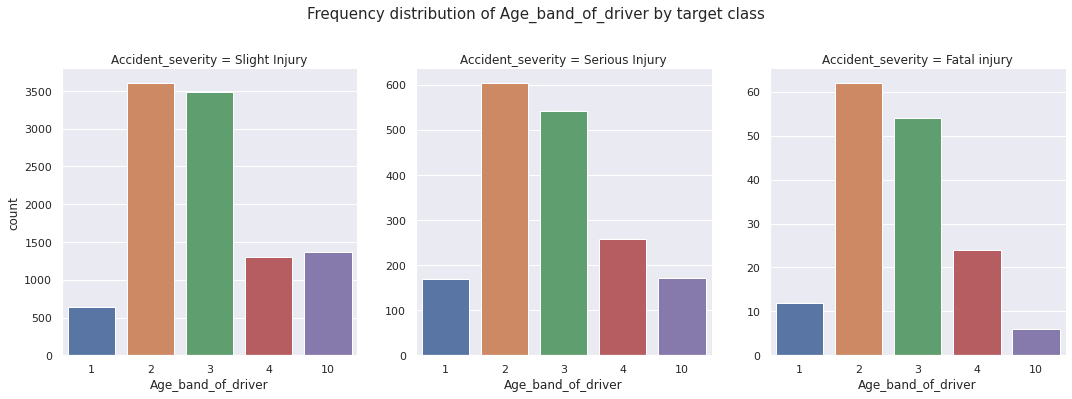

<Figure size 720x360 with 0 Axes>

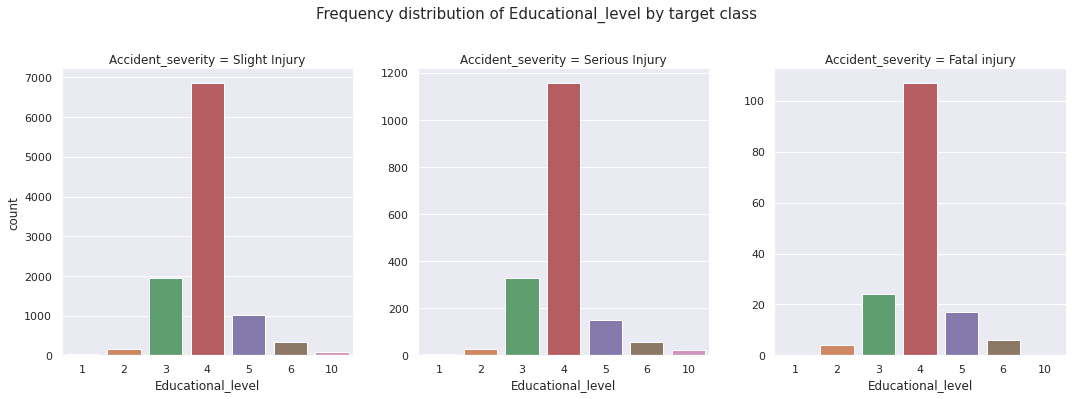

<Figure size 720x360 with 0 Axes>

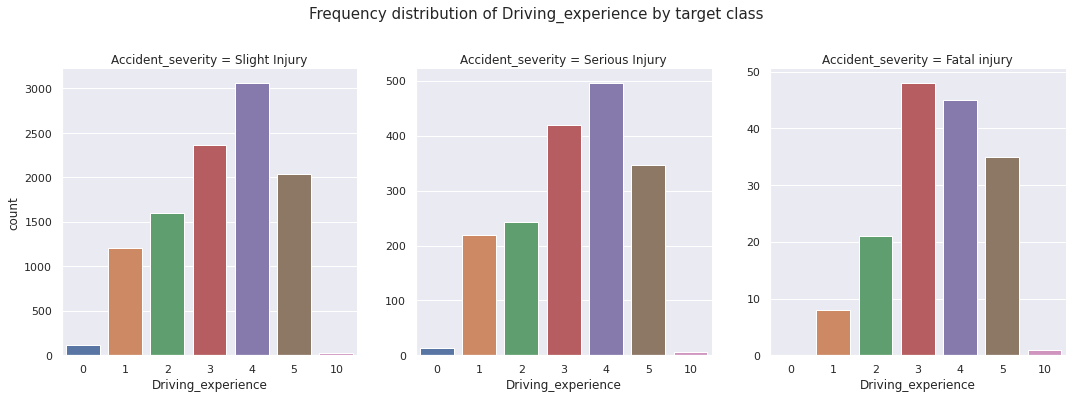

<Figure size 720x360 with 0 Axes>

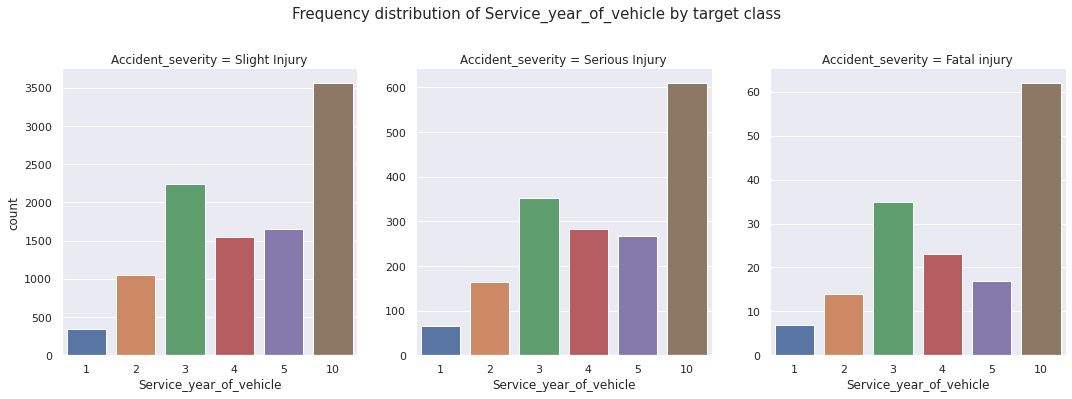

<Figure size 720x360 with 0 Axes>

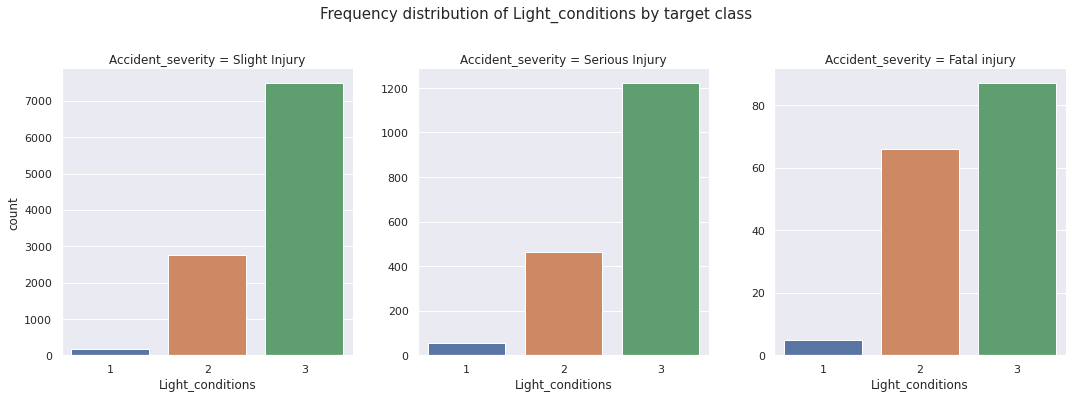

<Figure size 720x360 with 0 Axes>

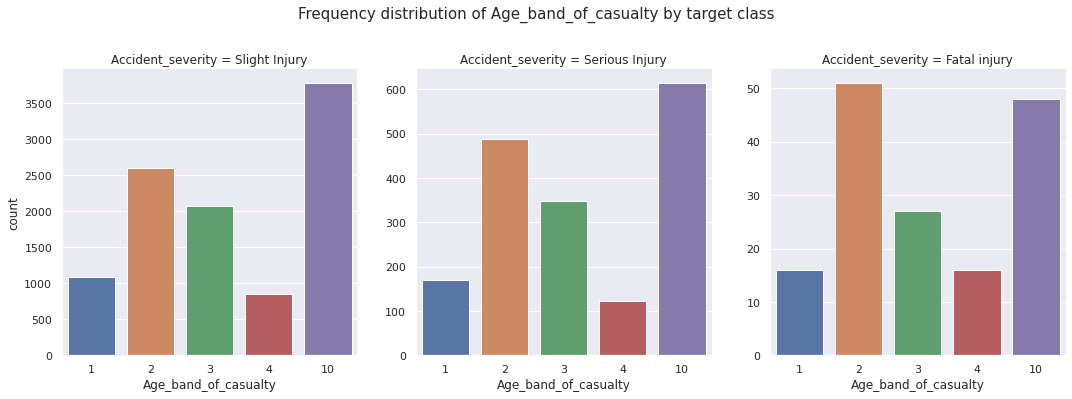

<Figure size 720x360 with 0 Axes>

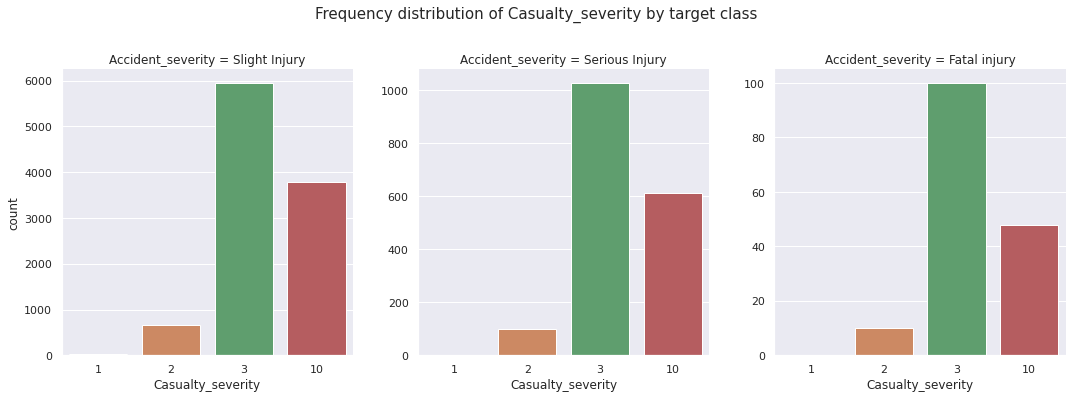

<Figure size 720x360 with 0 Axes>

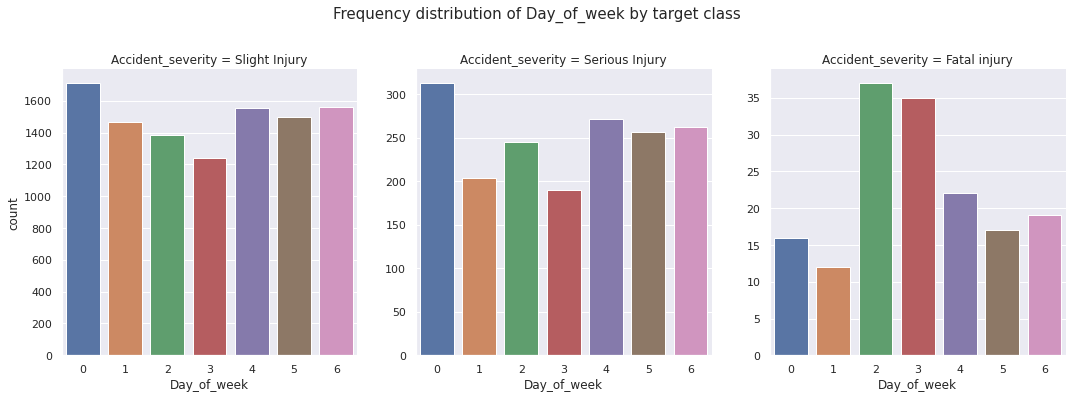

<Figure size 720x360 with 0 Axes>

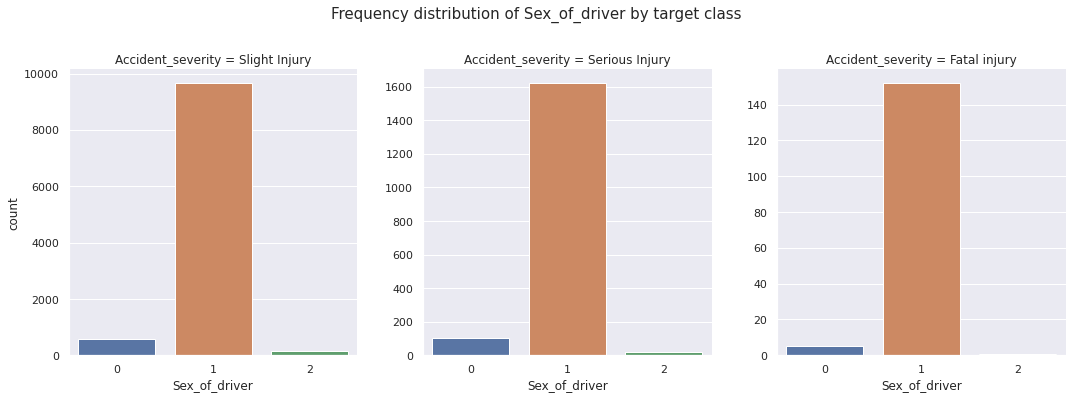

<Figure size 720x360 with 0 Axes>

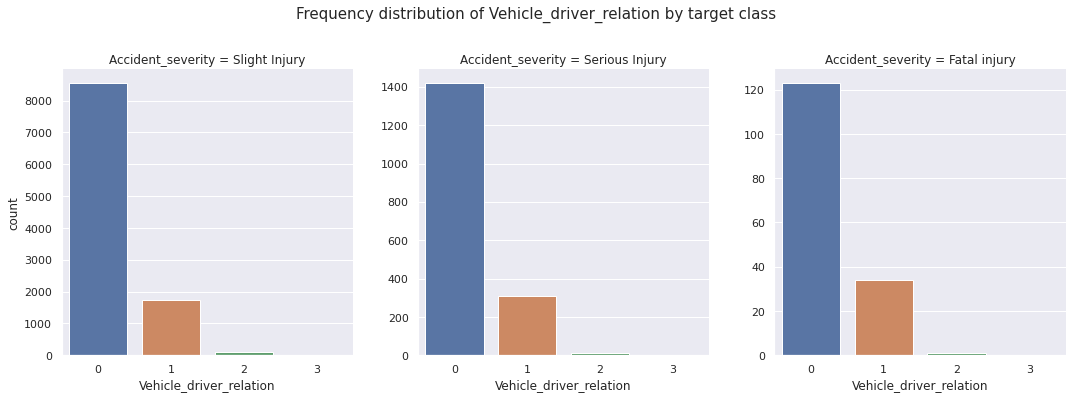

<Figure size 720x360 with 0 Axes>

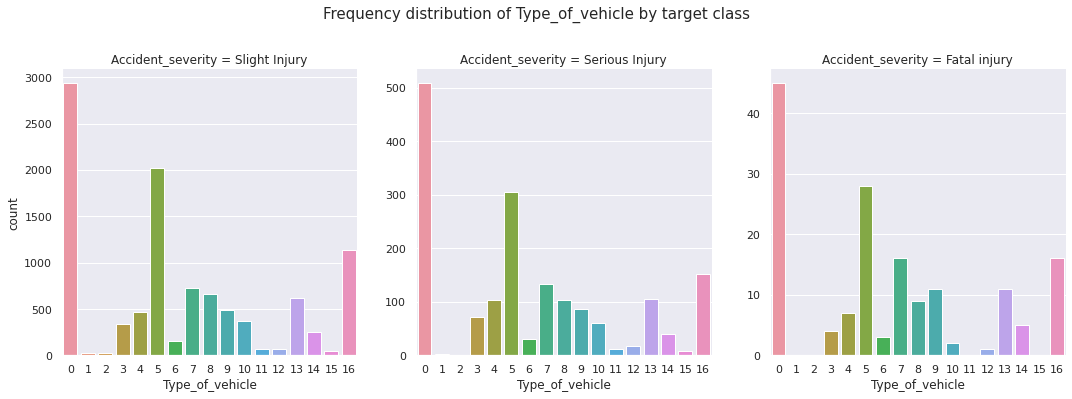

<Figure size 720x360 with 0 Axes>

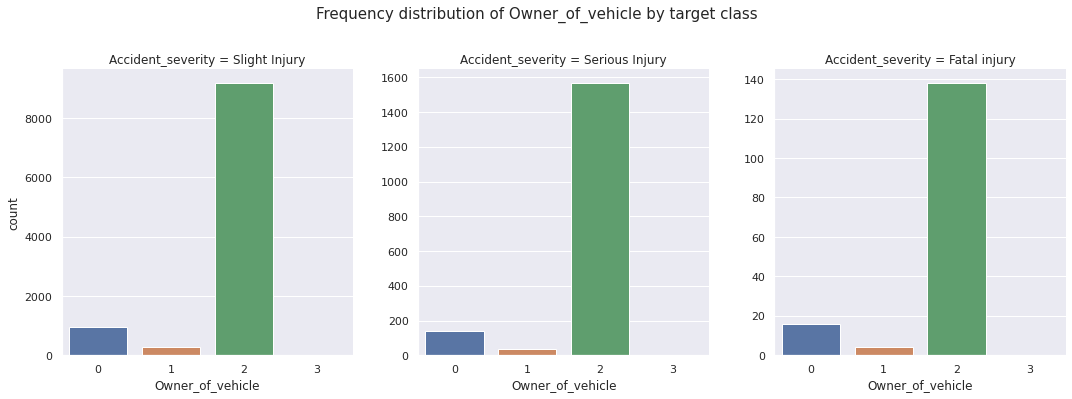

<Figure size 720x360 with 0 Axes>

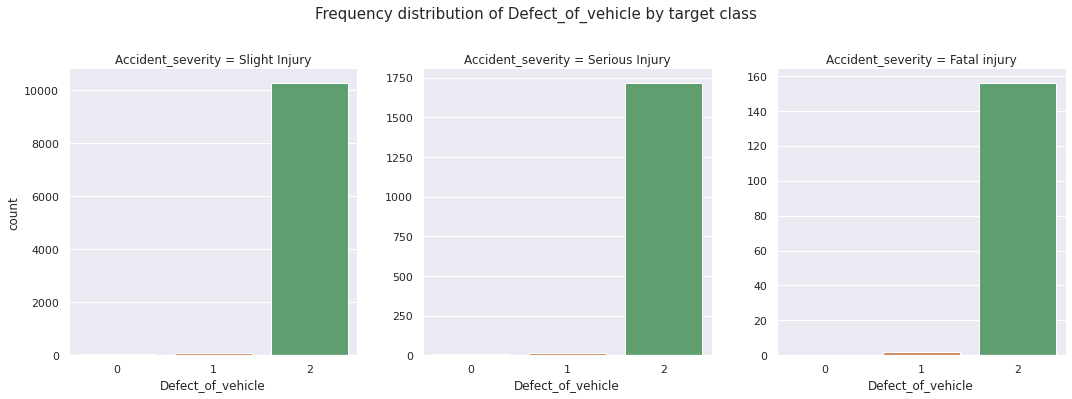

<Figure size 720x360 with 0 Axes>

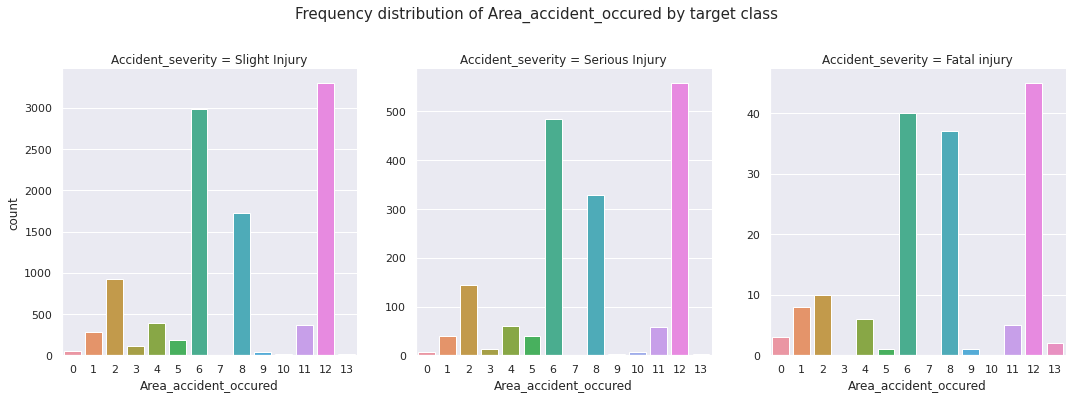

<Figure size 720x360 with 0 Axes>

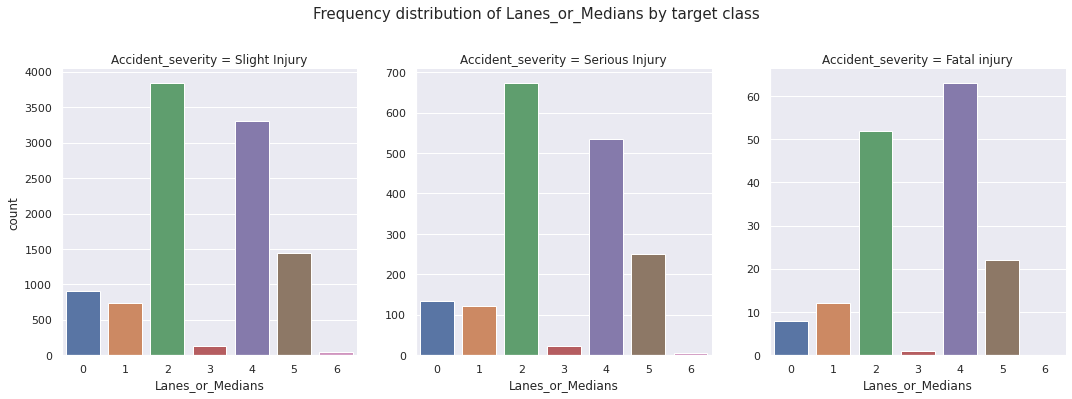

<Figure size 720x360 with 0 Axes>

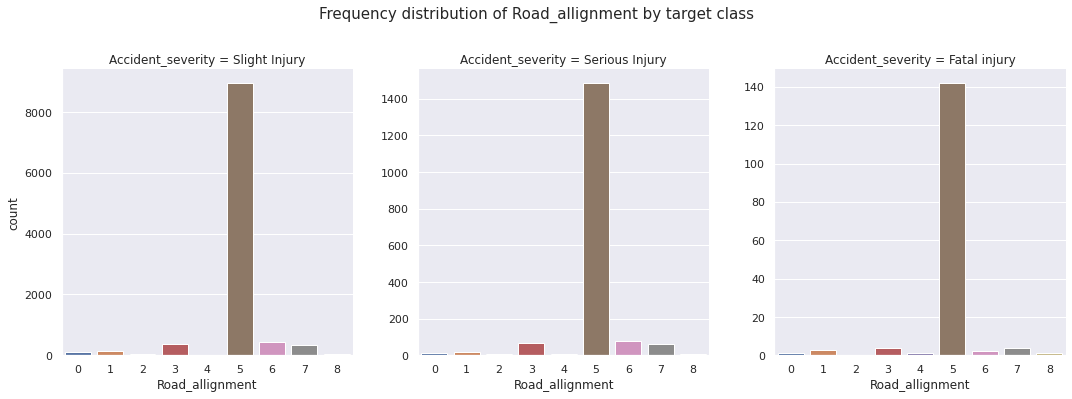

<Figure size 720x360 with 0 Axes>

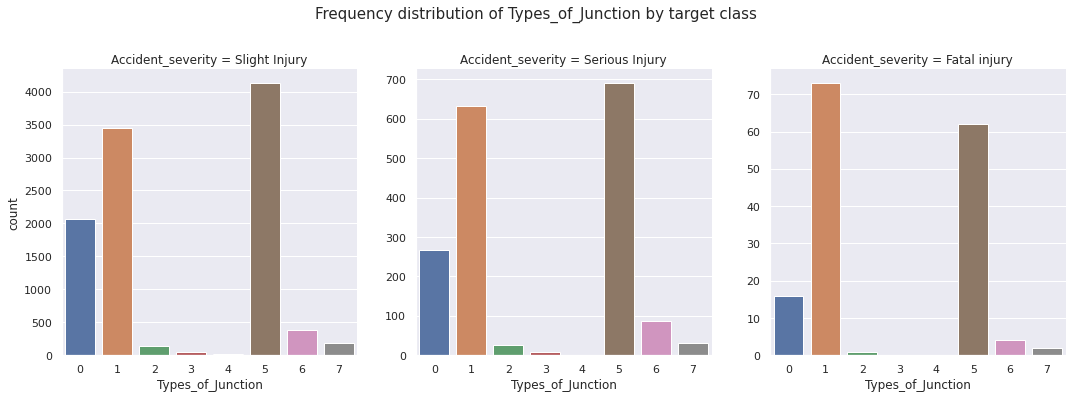

<Figure size 720x360 with 0 Axes>

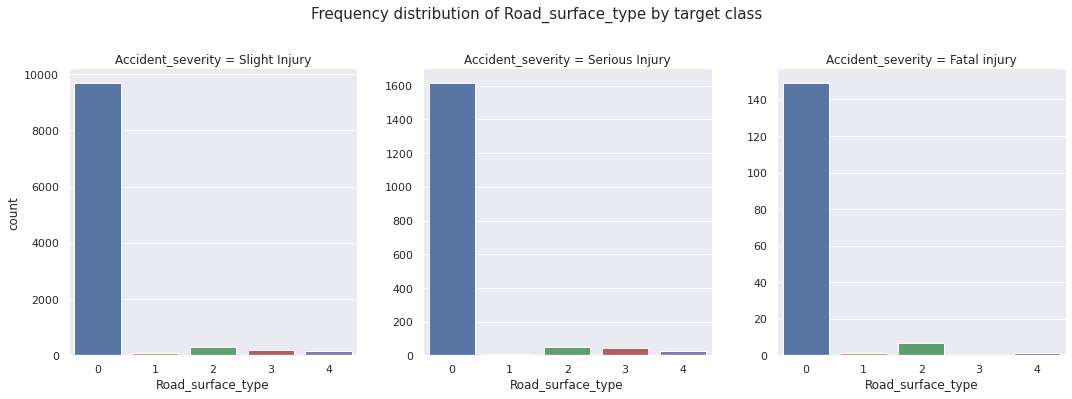

<Figure size 720x360 with 0 Axes>

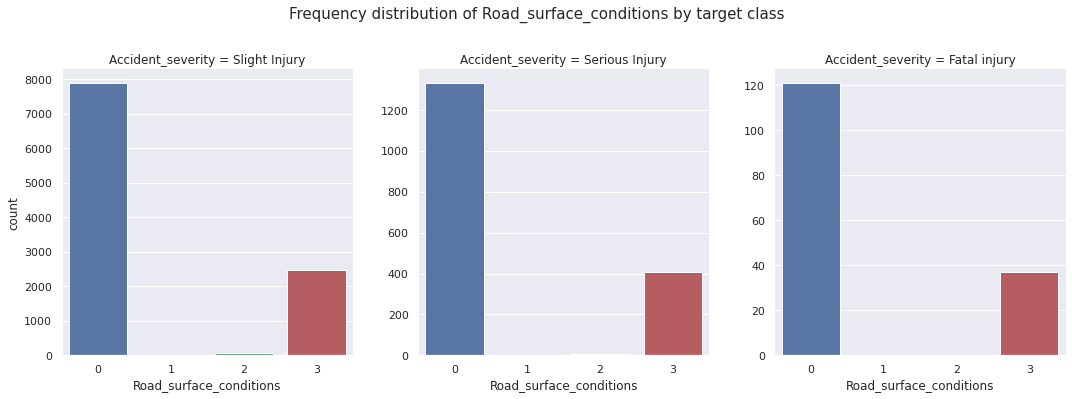

<Figure size 720x360 with 0 Axes>

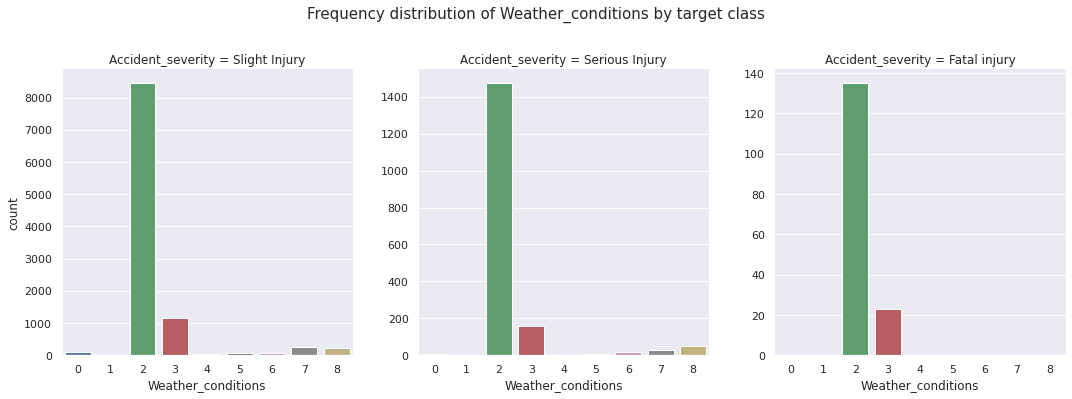

<Figure size 720x360 with 0 Axes>

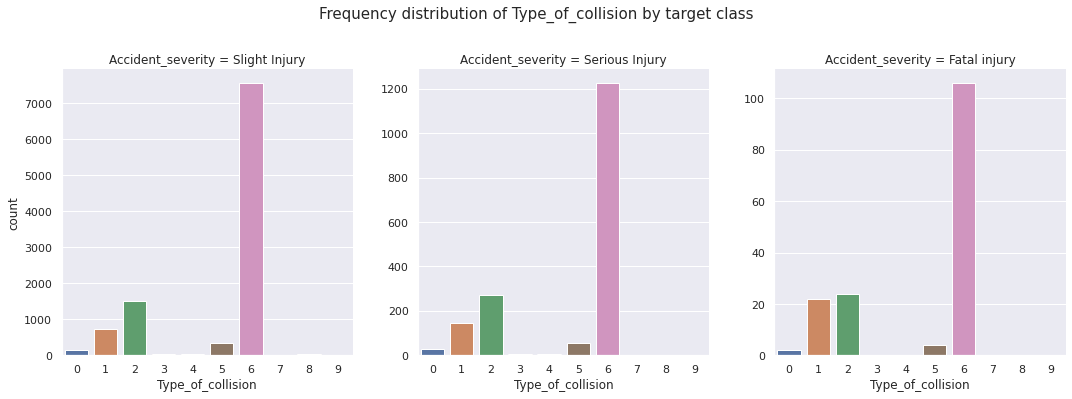

<Figure size 720x360 with 0 Axes>

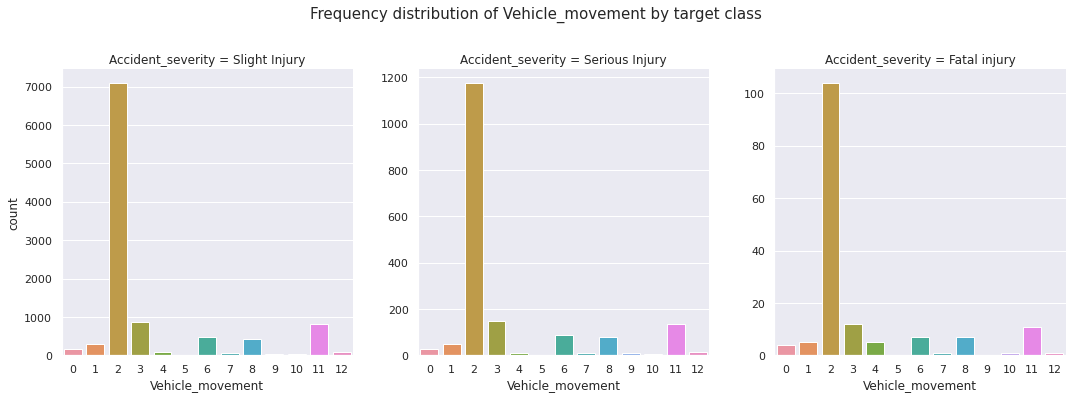

<Figure size 720x360 with 0 Axes>

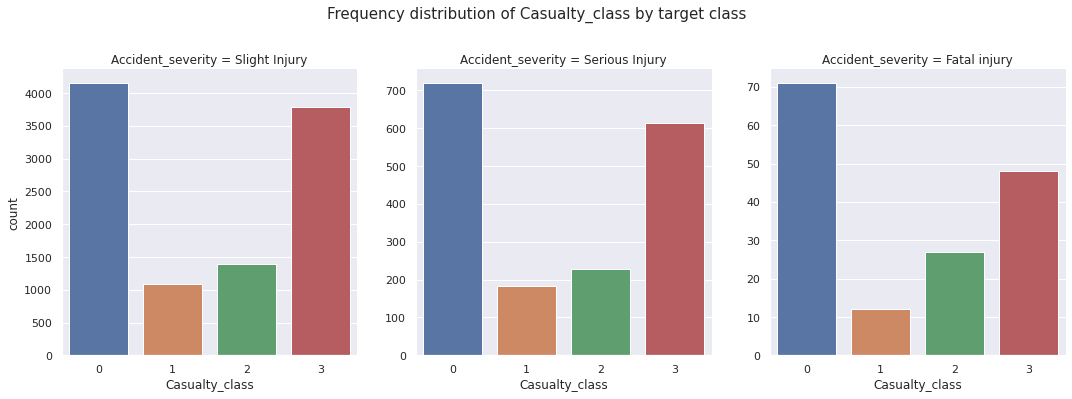

<Figure size 720x360 with 0 Axes>

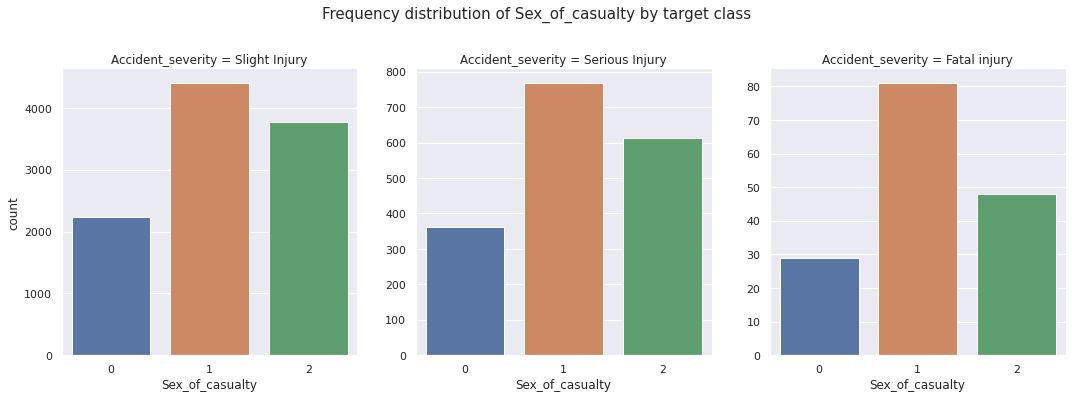

<Figure size 720x360 with 0 Axes>

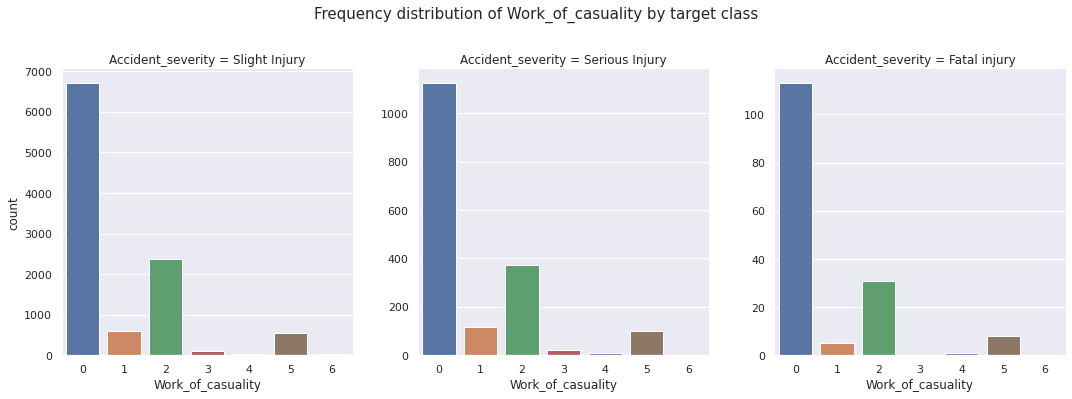

<Figure size 720x360 with 0 Axes>

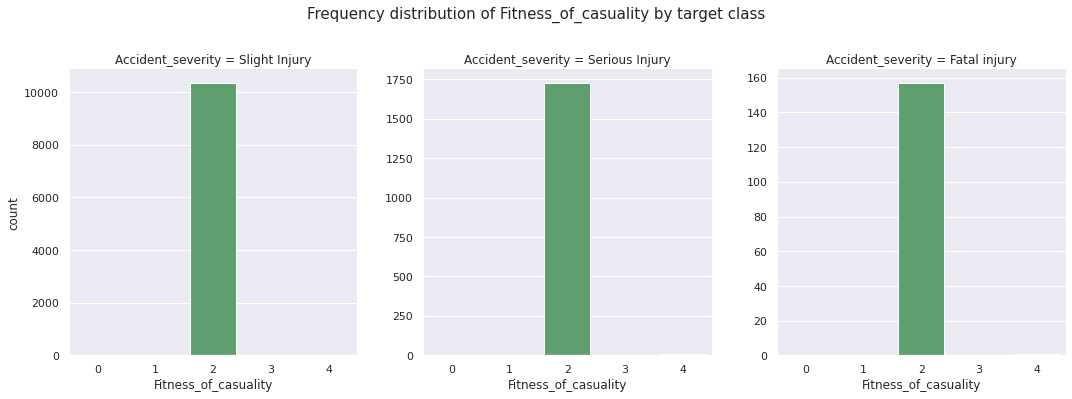

<Figure size 720x360 with 0 Axes>

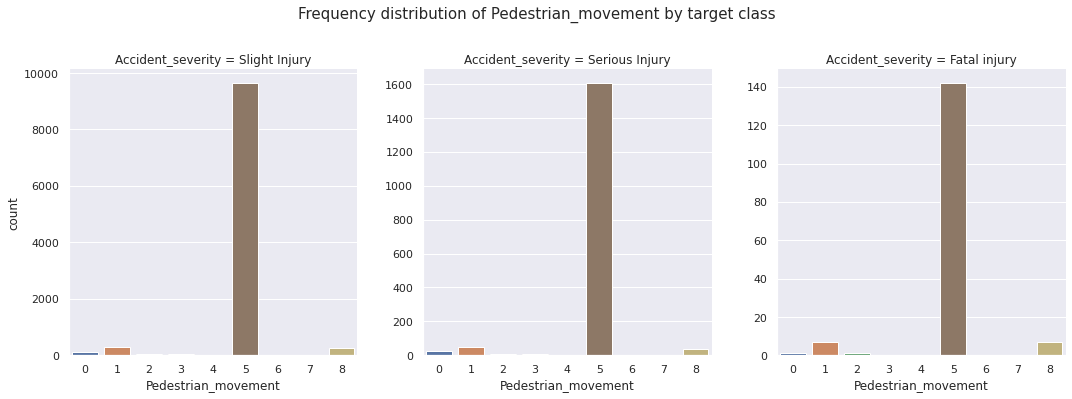

<Figure size 720x360 with 0 Axes>

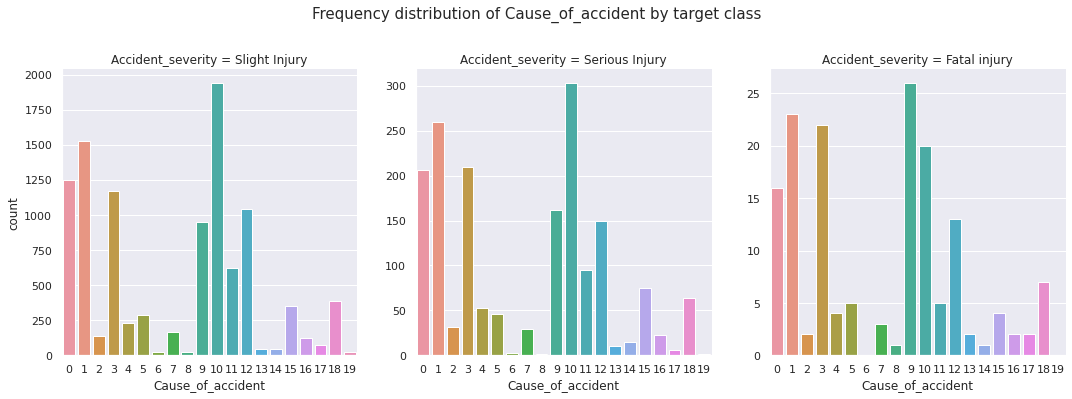

<Figure size 432x288 with 0 Axes>

In [50]:
# Catplot to compare frequency distributions of categorical features across target classes
for feature in ordinal_cols + nominal_cols:
    if feature != 'Accident_severity':
        plt.figure(figsize = (10, 5))
        catplot = sns.catplot(data = data, x = feature, col = 'Accident_severity', kind = 'count', sharey = False)
        plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
        plt.show()
plt.tight_layout()

In [51]:
# Correlation structure of features
def heatmap(data):
    plt.figure(figsize = (36, 27))
    sns.heatmap(data.corr(), annot = True, cmap = plt.cm.CMRmap_r)

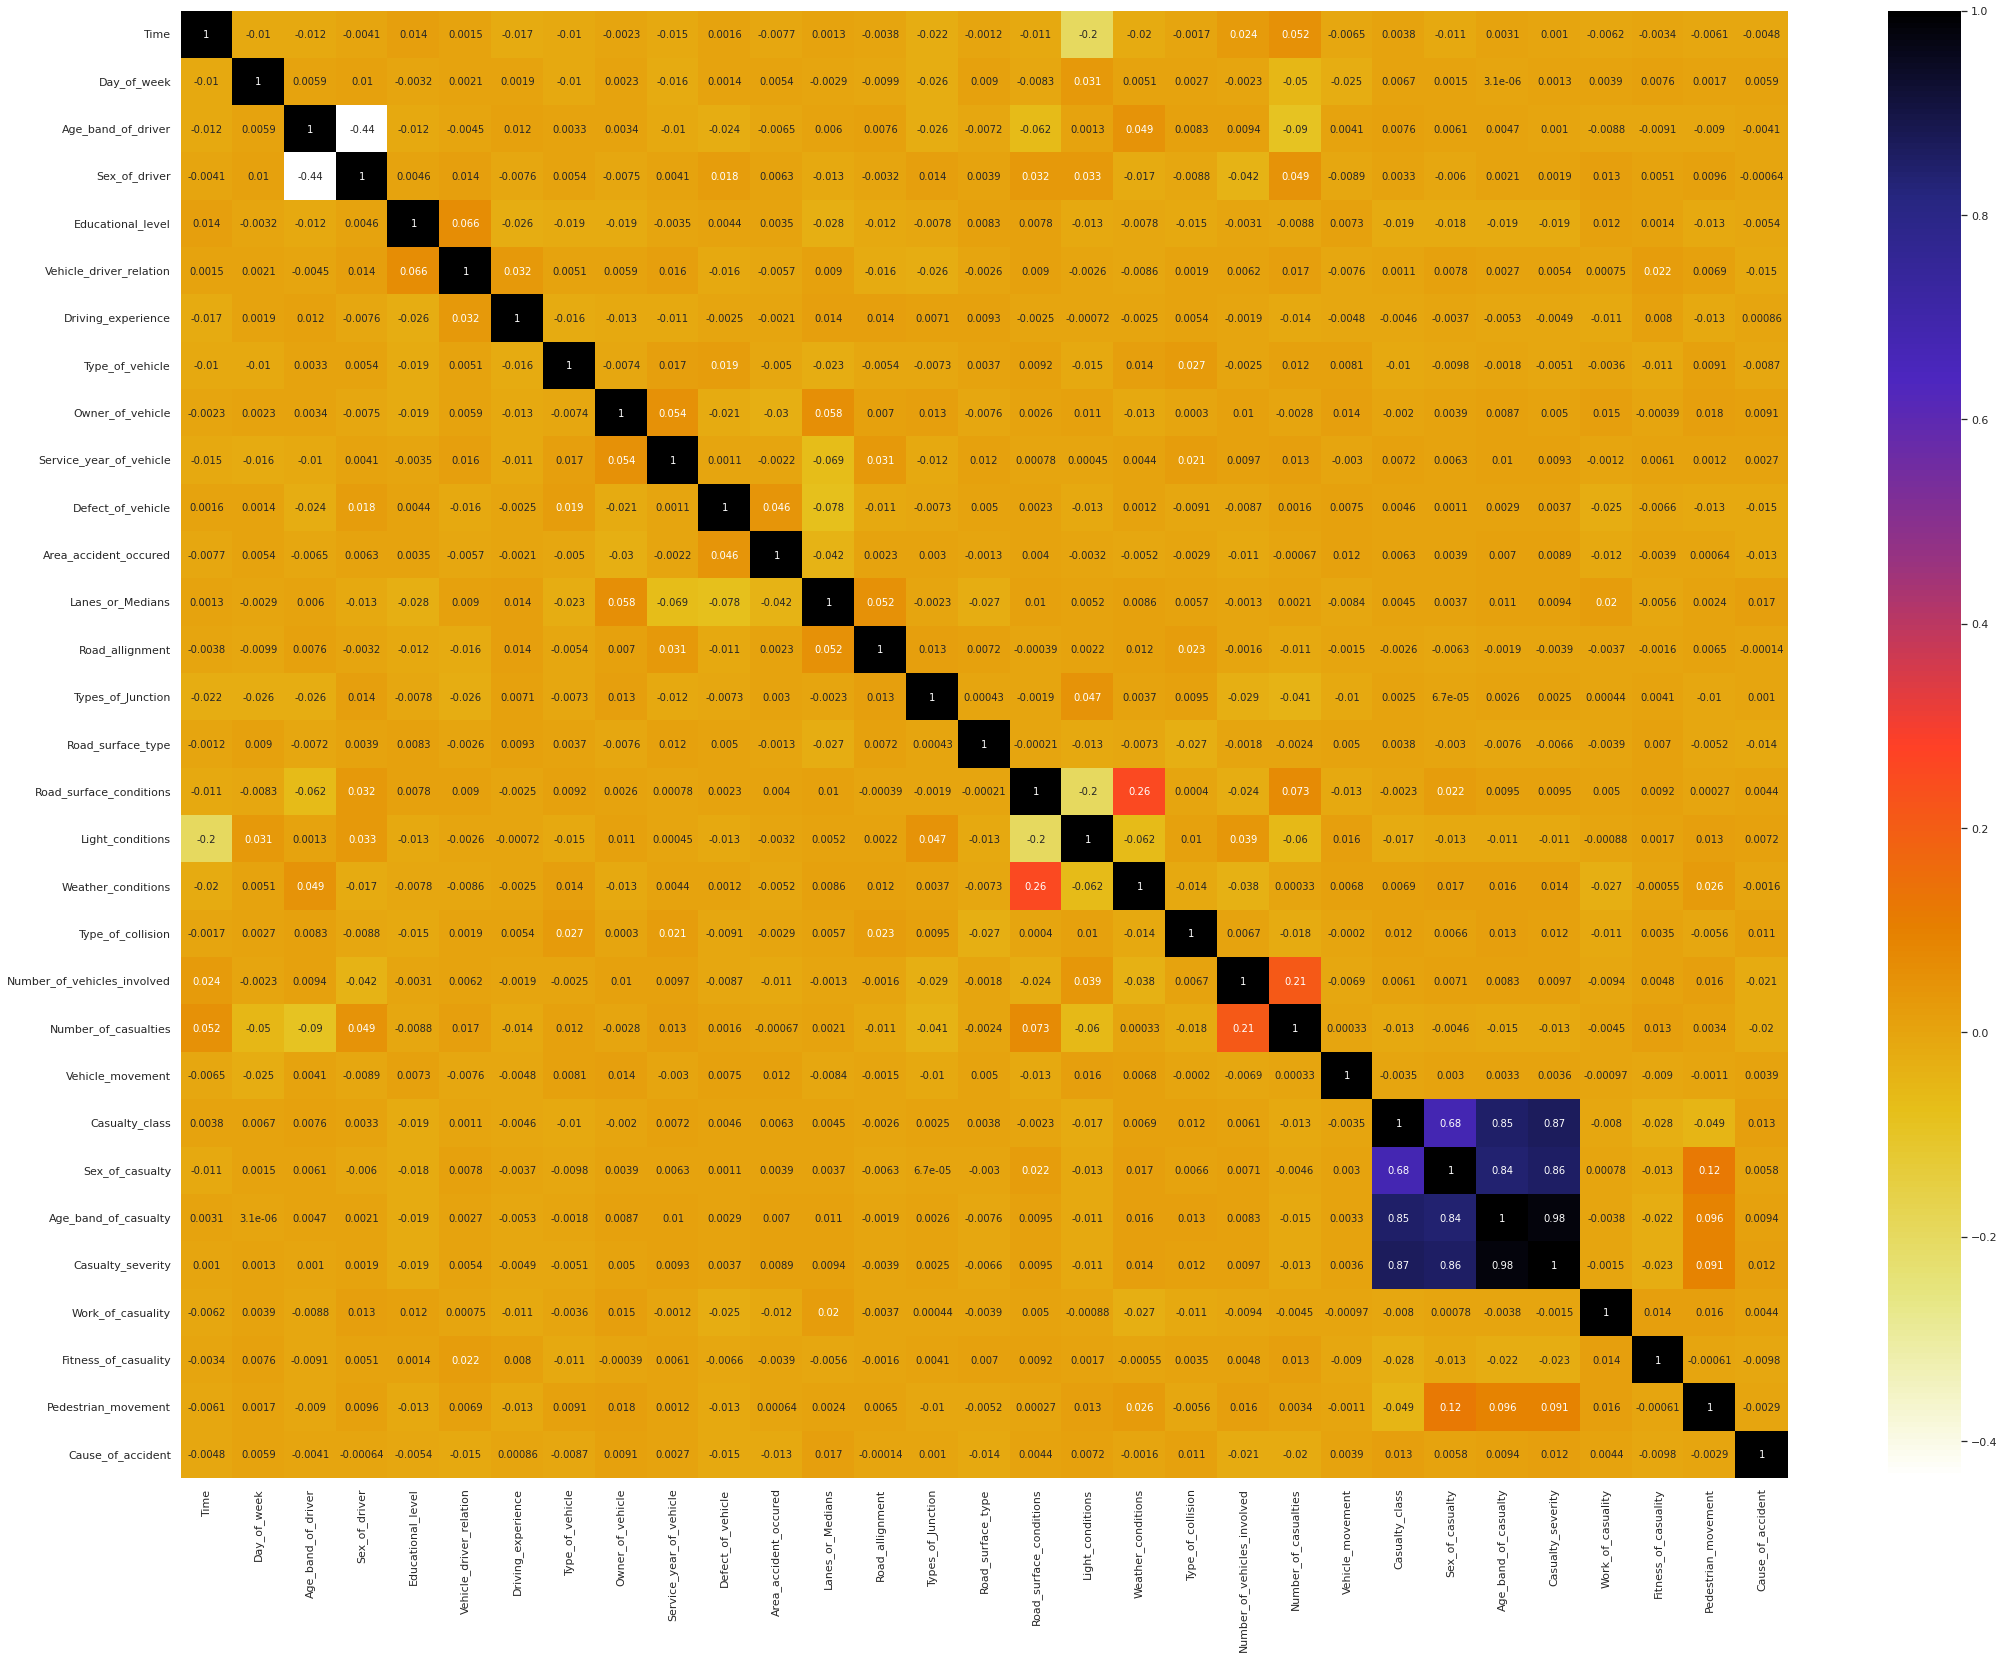

In [52]:
# Heatmap
data_heat = data.drop('Accident_severity', axis = 1)
heatmap(data_heat)

**Observation:** The features Casualty_class, Sex_of_casualty, Age_band_of_casualty and Casualty_severity are highly correlated.

In [53]:
# Drop columns
drop_cols = ['Casualty_class', 'Sex_of_casualty', 'Casualty_severity']
data = data.drop(drop_cols, axis = 1)

## 3.4. Predictor-Target Split

In [54]:
# Function to split predictor variables and target variable
def predictor_target_split(data, target):
    y = data[target] # target variable
    X = data.drop(target, axis = 1) # independent variables
    return X, y

In [55]:
X, y = predictor_target_split(data, 'Accident_severity')

## 3.5. Train-Test Split

Then we split the dataset into **training set** and **test set** using the **train_test_split** function.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

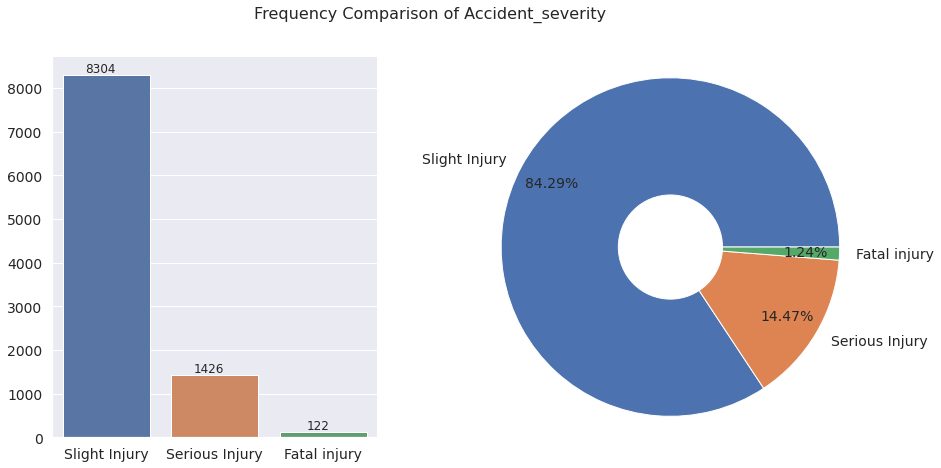

In [57]:
y_train_df = pd.DataFrame(y_train)
count_donut(y_train_df, 'Accident_severity')

## 3.6. Normalization

The converted **time** takes huge values and is likely to distort the training procedure. The next two function give two ways to normalize the time variable.

In [58]:
# Function to normalize time variable
def normalize_time(data, c = 1):
    data_normalized = data.copy(deep = True)
    if 'Time' in data_normalized.columns:
        if data_normalized['Time'].max() > c:   # To prevent unnecessary shrinkage
            data_normalized['Time'] = c * data_normalized['Time'] / (24*60*60)
    return data_normalized

In [59]:
# Function to standardize time variable
def standardize_time(data):
    data_standardized = data.copy(deep = True)
    if 'Time' in data_standardized.columns:
        data_standardized['Time'] = (data_standardized['Time'] - data_standardized['Time'].mean()) / data_standardized['Time'].std()
    return data_standardized

**Note:** Ideally the normalization or standardization is done on the training set and then the test set goes through the exact same transformation (possibly depending on properties of the training set). Here the transformation induced by the *normalize_time* function, which essentially rescales the data by a fixed multiplicative constant, is independent of the training set. In contrast, the transformation induced by *standardize_time* does depend on the mean and standard deviation of the 'Time' column in the training set.

In [60]:
X_train = normalize_time(X_train, c = 10)
X_test = normalize_time(X_test, c = 10)

## 3.7. Resampling

### Random under-sampling (RUS)

In [61]:
# Random under-sampling
def rus(X_train, y_train):
    
    # Combining predictor variables and target variable in the training set
    data_train = pd.concat([X_train, y_train], axis = 1)

    # Splitting the training set by target class
    data_train_slight = data_train[data_train['Accident_severity'] == 'Slight Injury']
    data_train_serious = data_train[data_train['Accident_severity'] == 'Serious Injury']
    data_train_fatal = data_train[data_train['Accident_severity'] == 'Fatal injury']
    
    # Under-sampling
    data_train_slight_rus = data_train_slight.sample(len(data_train_fatal))
    data_train_serious_rus = data_train_serious.sample(len(data_train_fatal))
    data_train_rus = pd.concat([data_train_slight_rus, data_train_serious_rus, data_train_fatal], axis = 0)
    
    # Splitting predictor variables and target variable
    X_train_rus = data_train_rus.drop('Accident_severity', axis = 1)
    y_train_rus = data_train_rus['Accident_severity']

    return X_train_rus, y_train_rus

### Random over-sampling (ROS)

In [62]:
# Random over-sampling
def ros(X_train, y_train):
    
    # Combining predictor variables and target variable in the training set
    data_train = pd.concat([X_train, y_train], axis = 1)

    # Splitting the training set by target class
    data_train_slight = data_train[data_train['Accident_severity'] == 'Slight Injury']
    data_train_serious = data_train[data_train['Accident_severity'] == 'Serious Injury']
    data_train_fatal = data_train[data_train['Accident_severity'] == 'Fatal injury']
    
    # Over-sampling
    data_train_serious_ros = data_train_serious.sample(len(data_train_slight), replace = 'True')
    data_train_fatal_ros = data_train_fatal.sample(len(data_train_slight), replace = 'True')
    data_train_ros = pd.concat([data_train_slight, data_train_serious_ros, data_train_fatal_ros], axis = 0)
    
    # Splitting predictor variables and target variable
    X_train_ros = data_train_ros.drop('Accident_severity', axis = 1)
    y_train_ros = data_train_ros['Accident_severity']

    return X_train_ros, y_train_ros

### Random under-sampling with imbalanced-learn library (RUS-IL)

In [63]:
# Random under-sampling with imbalanced-learn library
def rusil(X_train, y_train):
    rusil = RandomUnderSampler(random_state = 40, replacement = True)
    X_train_rusil, y_train_rusil = rusil.fit_resample(X_train, y_train)
    return X_train_rusil, y_train_rusil

### Random over-sampling with imbalanced-learn library (ROS-IL)

In [64]:
# Random over-sampling with imbalanced-learn library
def rosil(X_train, y_train):
    rosil = RandomOverSampler(random_state = 40)
    X_train_rosil, y_train_rosil = rosil.fit_resample(X_train, y_train)
    return X_train_rosil, y_train_rosil

### Synthetic minority over-sampling technique (SMOTE)

In [65]:
# Synthetic minority over-sampling technique
def smote(X_train, y_train):
    smote = SMOTE()
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

### Under-sampling via NearMiss (NM)

In [66]:
# Under-sampling via NearMiss
def nm(X_train, y_train):
    nm = NearMiss()
    X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)
    return X_train_nm, y_train_nm

In [67]:
# Frequency comparison of the target variable before and after resampling
def resampler(X_train, y_train, method = smote, countplot = True):
    if method not in [rus, ros, rusil, rosil, smote, nm]:
        print("Method invalid")
    else:
        X_train_new, y_train_new = method(X_train, y_train)
        if countplot == True:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
            ax1 = sns.countplot(y_train, ax = ax1)
            ax2 = sns.countplot(y_train_new, ax = ax2)
            ax2.set_ylabel('')
            plt.suptitle("Frequency distribution of target variable in the training set before and after resampling", y = 1.1, fontsize = 15)
            plt.subplots_adjust(wspace = 0.4)
            plt.show()
        return X_train_new, y_train_new

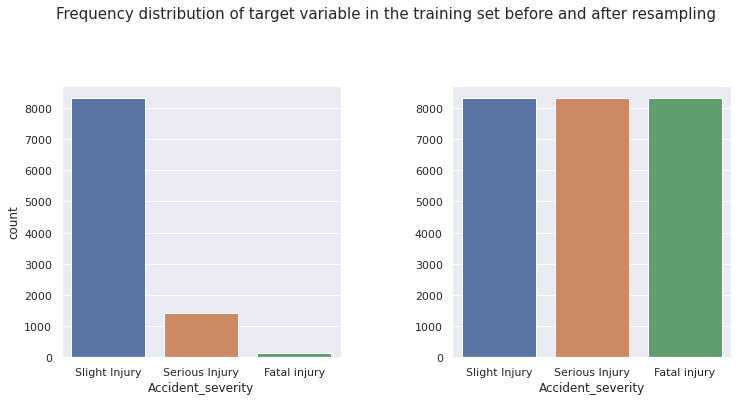

In [68]:
X_train, y_train = resampler(X_train, y_train, method = smote, countplot = True)

In [69]:
# Encoding the target variable
y_train = y_train.map(manual_encoder_dict['Accident_severity'])
y_test = y_test.map(manual_encoder_dict['Accident_severity'])

## 3.8. Feature Selection

### Chi-Squared Feature Selection


The chi-squared feature selection method requires the input data not to contain any negative values. The next function relocates each column with negative values for this purpose.

In [70]:
# Function to relocate each column of a dataframe to get rid of negative values
def spread_positivity(data):
    data_positive = data.copy(deep = True)
    for feature in data_positive.columns:
        if np.any(data_positive[feature] < 0) == True:
            data_positive[feature] = data_positive[feature] - data_positive[feature].min()
    return data_positive

The next function serves the same purpose for series.

In [71]:
# Function to relocate a series to get rid of negative values
def spread_positivity_for_series(data):
    data_positive = data.copy(deep = True)
    if np.any(data_positive < 0) == True:
        data_positive = data_positive - data_positive.min()
    return data_positive

In [72]:
# Chi-square feature selection
def feature_selection_chi2(X_train, y_train, X_test, k = 'all'):
    
    # Fixing negativity issues
    if np.any(X_train < 0) == True:
        X_train = spread_positivity(X_train)
    if np.any(y_train < 0) == True:
        y_train = spread_positivity_for_series(y_train)
    if np.any(X_test < 0) == True:
        X_test = spread_positivity(X_test)
     
    # Feature selection
    fs = SelectKBest(score_func = chi2, k = k)
    fs.fit(X_train, y_train)
    
    # Selected columns
    cols = fs.get_support(indices = True)
    
    # Output data
    X_train_fs = X_train.iloc[:, cols]
    X_test_fs = X_test.iloc[:, cols]
    
    return X_train_fs, X_test_fs, fs

### Mutual Information Feature Selection

In [73]:
# Mutual information feature selection
def feature_selection_mutual_information(X_train, y_train, X_test, k = 'all'):
     
    # Feature selection
    fs = SelectKBest(score_func = mutual_info_classif, k = k)
    fs.fit(X_train, y_train)
    
    # Selected columns
    cols = fs.get_support(indices = True)
    
    # Output data
    X_train_fs = X_train.iloc[:, cols]
    X_test_fs = X_test.iloc[:, cols]
    
    return X_train_fs, X_test_fs, fs

In [74]:
X_train, X_test, fs = feature_selection_chi2(X_train, y_train, X_test, k = 'all')

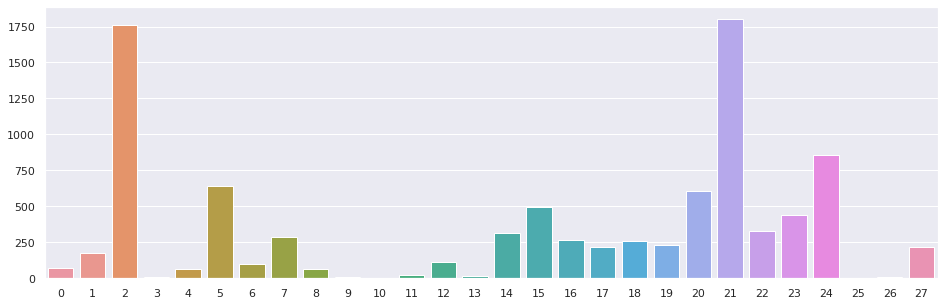

In [75]:
# Plotting the scores
plt.figure(figsize = (16, 5))
sns.barplot(x = [i for i in range(len(fs.scores_))], y = fs.scores_)
plt.show()

# 4. Baseline Models

In [76]:
# Computation of confusion matrix
def conf_mat(y_pred, y_test):
    class_names = ['Slight', 'Serious', 'Fatal']
    tick_marks_y = [0.5, 1.5, 2.5]
    tick_marks_x = [0.5, 1.5, 2.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(3), range(3))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [77]:
# Summary dictionary initialization
f1_dict = {}

## 4.1. Decision Tree

Weighted F1-score on the test set: 0.7281115171652008


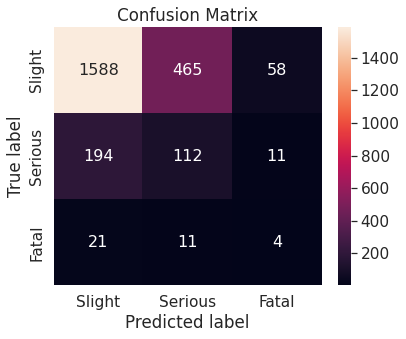

In [78]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Decision Tree'] = score
conf_mat(y_pred, y_test)

## 4.2. Random Forest

Weighted F1-score on the test set: 0.7860504489085849


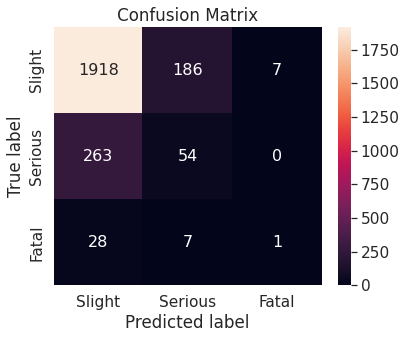

In [79]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

## 4.3. XGBoost Classifier

Weighted F1-score on the test set: 0.726461997231322


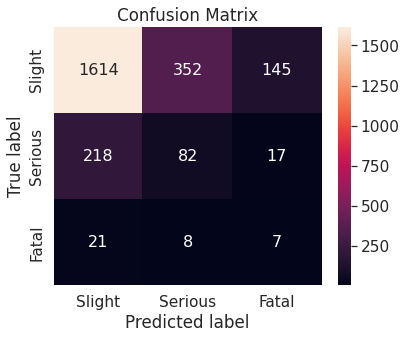

In [80]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['XGBoost'] = score
conf_mat(y_pred, y_test)

## 4.4. ExtraTress Classifier 

Weighted F1-score on the test set: 0.8024980745445052


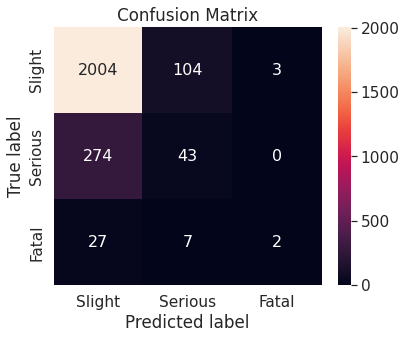

In [81]:
extree = ExtraTreesClassifier()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['ExtraTrees'] = score
conf_mat(y_pred, y_test)

In [82]:
# Summary dataframe
f1_df = pd.DataFrame(f1_dict.items(), columns = ['Classifier', 'F1-score'])
f1_df.sort_values(by = ['F1-score'], ascending = False)

Classifier  F1-score
3     ExtraTrees  0.802498
1  Random Forest  0.786050
0  Decision Tree  0.728112
2        XGBoost  0.726462

# 5. Hyperparameter Tuning

In [83]:
# Summary dictionary initialization
f1_dict_ht = {}

## 5.1. Random Forest

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best weighted F1-score: 0.9263336709815801
 
Weighted F1-score on the test set: 0.7911143851405856


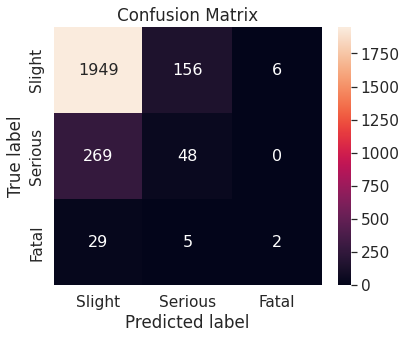

In [84]:
# Hyperparameter tuning for Random Forest
cv = KFold(n_splits = 3, shuffle = True, random_state = 20).split(X = X_train, y = y_train)
rf = RandomForestClassifier()
params_rf = {'n_estimators': [100, 200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt', 'log2'],
          'class_weight': ['balanced', None]
          }
gsearch_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_rf_fit = gsearch_rf.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_rf.best_params_))
print("Best weighted F1-score: {}".format(gsearch_rf.best_score_))
print(" ")

# Random Forest model evaluation on the test set
rf_best = gsearch_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
score = f1_score(y_test, y_pred_rf, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['Random Forest'] = score
conf_mat(y_pred_rf, y_test)

## 5.2. ExtraTrees Classifier

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best weighted F1-score: 0.9413996793208809
 
Weighted F1-score on the test set: 0.8099458643831428


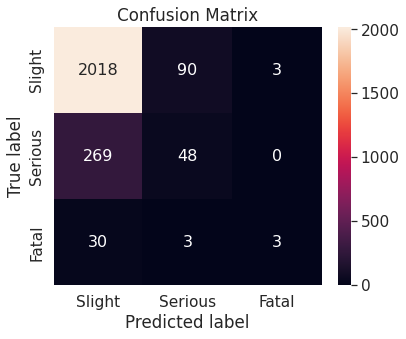

In [85]:
# Hyperparameter tuning for ExtraTrees
cv = KFold(n_splits = 3, shuffle = True, random_state = 20).split(X = X_train, y = y_train)
extree = ExtraTreesClassifier()
params_extree = {'criterion': ['gini', 'entropy'],
              'max_depth': [None],
              'min_samples_split': [2, 4, 6],
              'ccp_alpha': [0.0, 0.5],
              'class_weight': ['balanced']
              }
gsearch_extree = GridSearchCV(estimator = extree, param_grid = params_extree, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_extree_fit = gsearch_extree.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_extree.best_params_))
print("Best weighted F1-score: {}".format(gsearch_extree.best_score_))
print(" ")

# ExtraTress model evaluation on the test set
extree_best = gsearch_extree.best_estimator_
extree_best.fit(X_train, y_train)
y_pred_extree = extree_best.predict(X_test)
score = f1_score(y_test, y_pred_extree, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['ExtraTrees'] = score
conf_mat(y_pred_extree, y_test)

In [86]:
# Summary dataframe
f1_df_ht = pd.DataFrame(f1_dict_ht.items(), columns = ['Classifier', 'F1-score'])
f1_df_ht.sort_values(by = ['F1-score'], ascending = False)

Classifier  F1-score
1     ExtraTrees  0.809946
0  Random Forest  0.791114

# 6. Explainable AI

In [87]:
# Loading JavaScript library
shap.initjs()

# Sampling from test data predictors
X_test_sample = X_test.sample(100)

# Predicted values corresponding to the sample
y_pred_extree_sample = np.array(pd.Series(data = y_pred_extree, index = X_test.index)[X_test_sample.index])

# Explainer
explainer = shap.TreeExplainer(extree_best)

# Computing SHAP values based on the sample
shap_values = explainer.shap_values(X_test_sample)

## Global interpretation

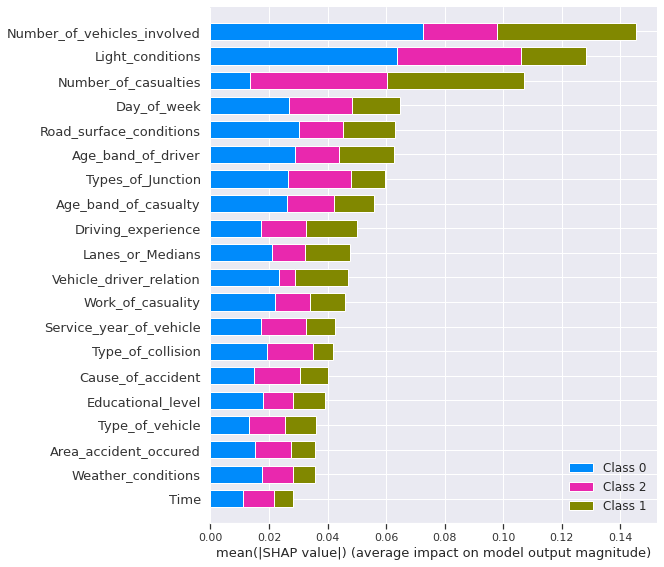

In [88]:
# Summary plot
shap.summary_plot(shap_values = shap_values, features = X_test_sample, plot_type = 'bar')

## Local interpretation

### Explaining single prediction

In [89]:
# Reverse encoder for the target variable
target_reverse_encoder = {1: "Slight injury", 2: "Serious injury", 3: "Fatal injury"}

In [90]:
# Force plot
shap.initjs()
row = math.floor(len(y_pred_extree_sample)/2)
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.force_plot(base_value = explainer.expected_value[i],
                            shap_values = shap_values[i][row],
                            features = X_test_sample.values[row],
                            feature_names = X_test_sample.columns))
print("Prediction: {}".format(target_reverse_encoder[y_pred_extree_sample[row]]))

Slight injury


Serious injury


Fatal injury


Prediction: Slight injury


Slight injury


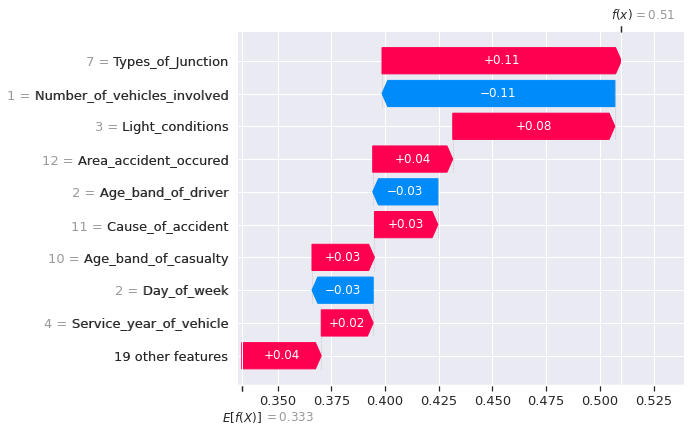

None

 
Serious injury


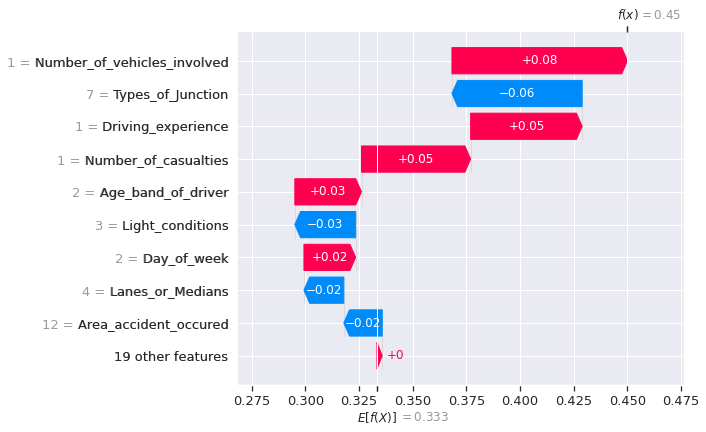

None

 
Fatal injury


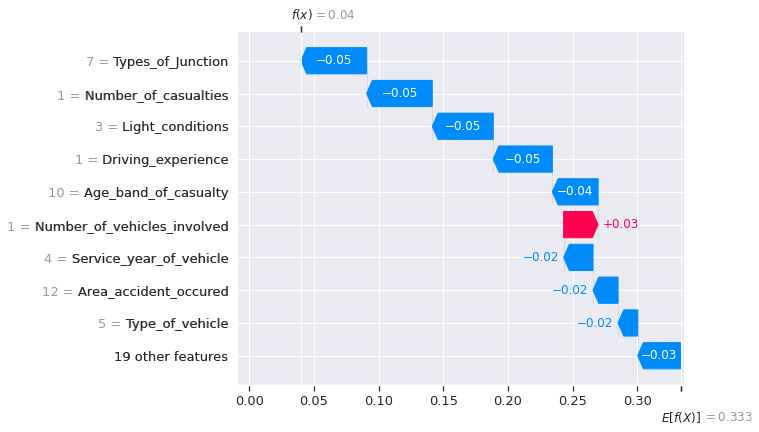

None

 
Prediction: Slight injury


In [91]:
# Waterfall plot
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.waterfall_plot(shap.Explanation(values = shap_values[i][row],
                                                 base_values = explainer.expected_value[i],
                                                 data = X_test_sample.iloc[row],
                                                 feature_names = X_test_sample.columns.tolist())))
    print(" ")
print("Prediction: {}".format(target_reverse_encoder[y_pred_extree_sample[row]]))

Slight injury


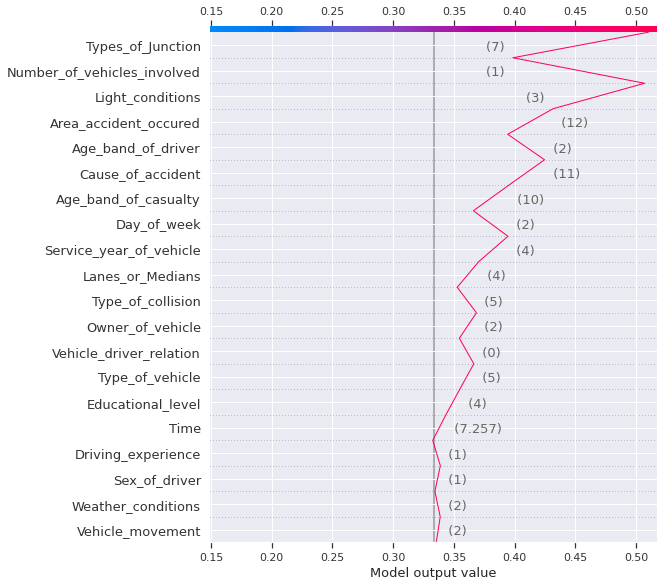

None

 
Serious injury


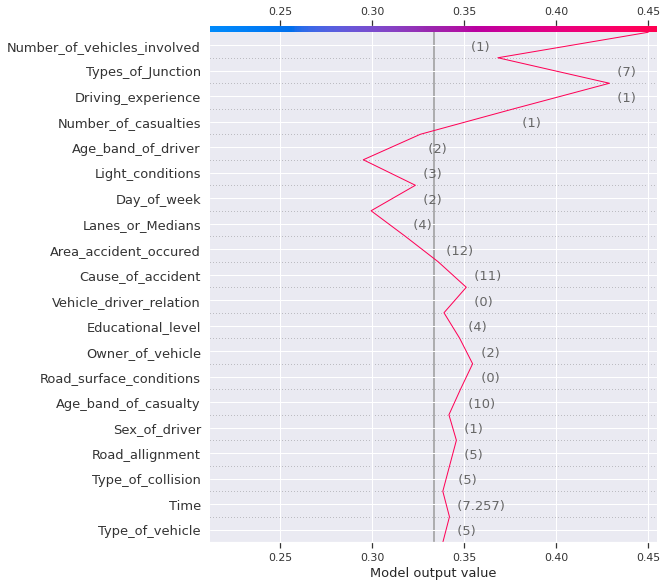

None

 
Fatal injury


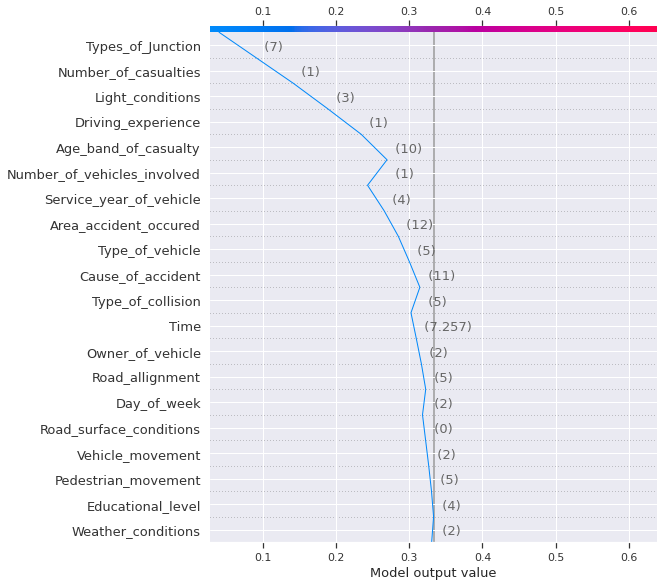

None

 
Prediction: Slight injury


In [92]:
# Decision plot
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.decision_plot(base_value = explainer.expected_value[i], 
                               shap_values = shap_values[i][row],
                               features = X_test_sample.iloc[row, :],
                               feature_names = X_test_sample.columns.tolist()))
    print(" ")
print("Prediction: {}".format(target_reverse_encoder[y_pred_extree_sample[row]]))

### Explaining multiple predictions

In [93]:
# Force plot
shap.initjs()
begin = row
end = min(row + 200, len(X_test_sample))
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.force_plot(base_value = explainer.expected_value[i],
                            shap_values = shap_values[i][begin:end],
                            features = X_test_sample.iloc[begin:end, :],
                            feature_names = X_test_sample.columns))
    print(" ")

Slight injury


 
Serious injury


 
Fatal injury


Slight injury


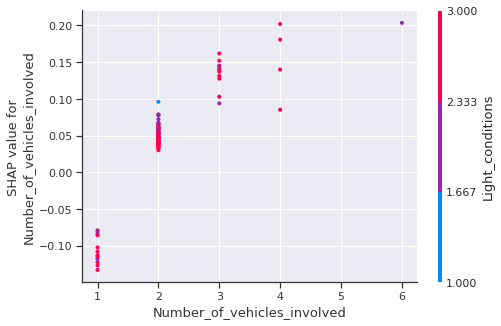

None

 
Serious injury


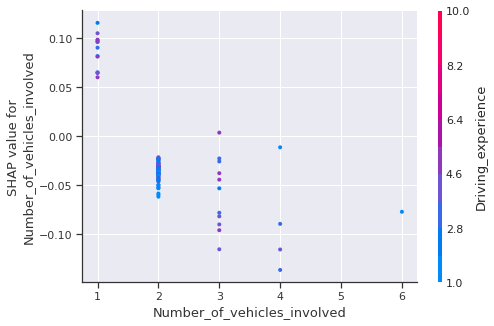

None

 
Fatal injury


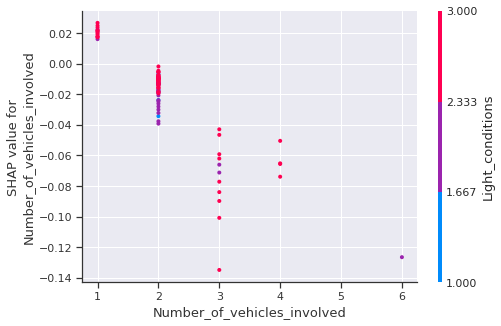

None

In [94]:
# Dependence plot
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.dependence_plot(ind = 'Number_of_vehicles_involved',
                                 shap_values = shap_values[i],
                                 features = X_test_sample))
    print(" ")

Slight injury


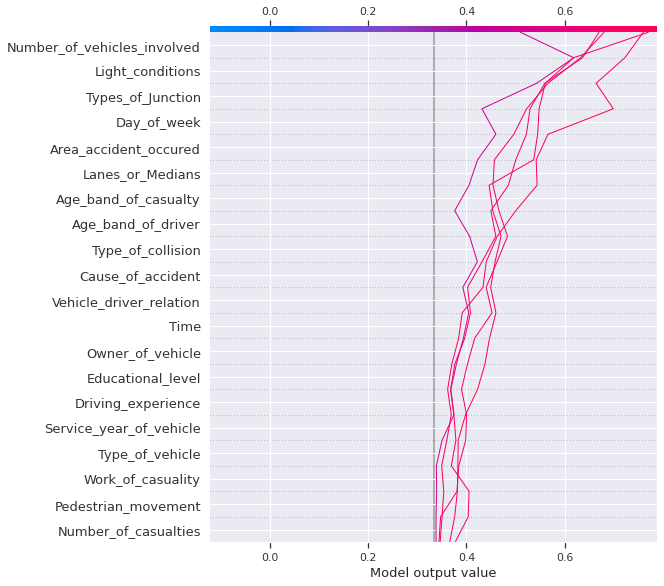

None

 
Serious injury


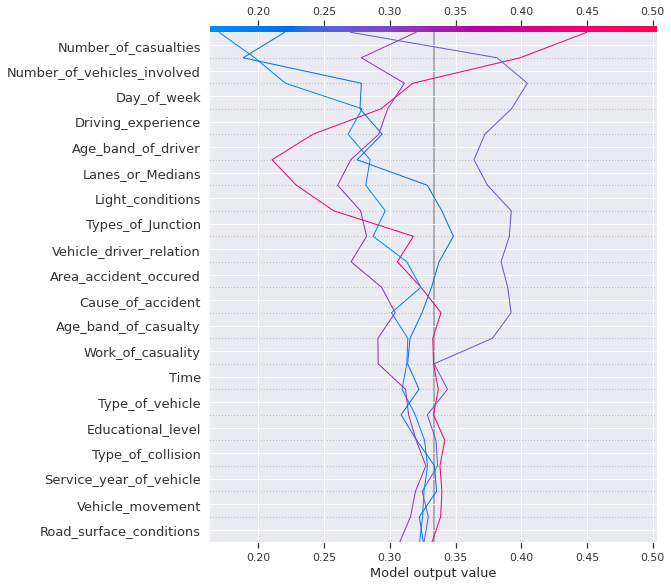

None

 
Fatal injury


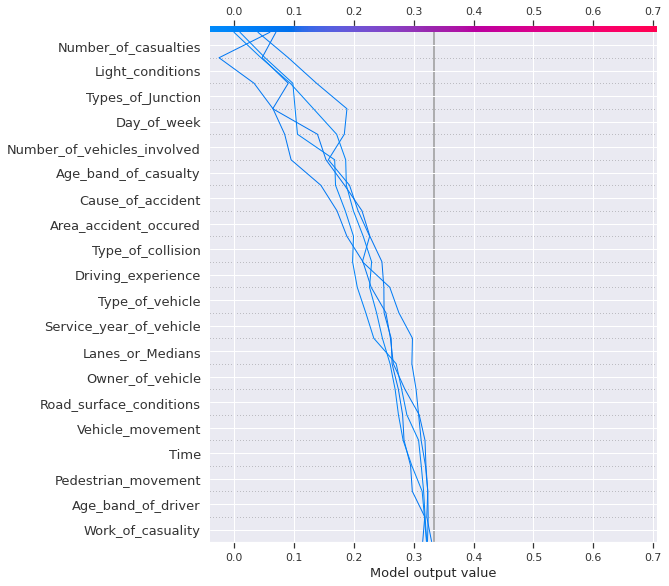

None

 
Predictions: ['Slight injury', 'Slight injury', 'Slight injury', 'Slight injury', 'Slight injury']


In [95]:
# Decision plot
begin = row
end = min(row + 5, len(X_test_sample))
for i in range(np.array(shap_values).shape[0]):
    print(target_reverse_encoder[i+1])
    display(shap.decision_plot(base_value = explainer.expected_value[i], 
                               shap_values = shap_values[i][begin:end],
                               features = X_test_sample.iloc[begin:end, :],
                               feature_names = X_test_sample.columns.tolist()))
    print(" ")
print("Predictions: {}".format([target_reverse_encoder[y_pred_extree_sample[x]] for x in np.arange(begin, end)]))

# Acknowledgements

- [Road Traffic Accidents](https://www.kaggle.com/saurabhshahane/road-traffic-accidents) dataset by [Saurabh Shahane](https://www.kaggle.com/saurabhshahane)

# References

- [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
- [One-hot](https://en.wikipedia.org/wiki/One-hot)

In [96]:
# Runtime and memory usage
stop = time.time()
process = psutil.Process(os.getpid())

In [97]:
print("Process runtime: {:.2f} seconds".format(float(stop - start)))
print("Process memory usage: {:.2f} MB".format(float(process.memory_info()[0]/(1024*1024))))

Process runtime: 652.59 seconds
Process memory usage: 2191.92 MB
